# Programing exercise 5: ODE integrators

Due on Monday, 26.11.2018, 14.15h

### Total: 100 points

__This exercise sheet has been solved by:__ Mathieu Kaltschmidt and Carl von Randow

## The problem

We will again consider the collective Ising spin-model with a transverse field, as in programming exercise 4, which is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. We studied this model in detail on the previous exercise sheet using exact diagonalization. Now we want to test how different numerical integrators perform on this problem and use exact diagonalziation as a benchmark.

In [1]:
# load standard libraries
import numpy as np   
import numpy.linalg as LA
import matplotlib.pyplot as plt   
%matplotlib inline
import time as time
import scipy.sparse as sparse

#Plot settings
plt.style.use('seaborn-talk')
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.figsize"][0] = 12
plt.rcParams["figure.figsize"][1] = 8

### Exact diagonalization code

Here is an example implemetation of the exact diagonalization which you can use and compare to.

Definitions for building the Hamiltonian for this problem:

In [2]:
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def buildH(N,omega):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N -omega*Sx 

### Our solution:

We decided to put all the given code together into new methods which calculate and plot all the different parameters we want to observe throughout this exercise sheet. 
This allows us to avoid a confusing notebook structure and to concentrate on the different comparisons. <br> 
First of all we calculate the time evolution using exact diagonalization. This will be used to benchmark the performance of the numerical integrators.

In [3]:
#Initial parameter
omega = 0.6

#### Summary of what we are doing to compare the results:

We integrate with a constant step size to compare the resulting accuracy. <br>
Then we loop over the step size to see how the error depends on it.
We are only interested in the output observables at the points defined by the ED benchmark, i.e. subdivide time steps. <br>

After that we plot the  deviation as a function of the step size. A double log scale is chosen. <br>

The deviation of $S_x$ at the final time is observed as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

#### Writing some methods to do the full analysis for a given list of integration methods:

In [31]:
#First step: Exact diagonalization
def exact_diagonalization(dt, tend, N):
    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0,dt*tsteps,tsteps+1)
    tvecED = tvec

    dim = N+1
    ini = np.eye(1,dim,0)[0]
    Sz = buildSz(N)
    Sx = buildSx(N)
    Sz2 = Sz @ Sz
    Hmat = buildH(N,omega)
    
    observables = 1j*np.zeros((2,len(tvec)))
    
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i] = Szval
        observables[1,i] = Sxval
    t2=time.time()
    print('time for ED was '+str(t2-t1))

    if np.max(observables.imag) > 0.001:
        print("Some observables have non-zero imaginary parts!! (ED)")

    observablesED = observables.real
    return observablesED

#Second step: method to call different integrators (self-implemented or from the ODE class)
def one_integrator(integrator, dt, tend, N, observablesED, input_istepsize = 10, analyze_step_size = True, difference_plots = False): 
    
    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0,dt*tsteps,tsteps+1)
    tvec_integrator = tvec;
    
    dim = N+1
    ini = np.eye(1,dim,0)[0]
    Sz = buildSz(N)
    Sx = buildSx(N)
    Sz2 = Sz @ Sz
    Hmat = buildH(N,omega)
    
    #for including the integrators from scipy.integrate_ode
    if(str(type(integrator)) == "<class 'scipy.integrate._ode.ode'>" or \
           str(type(integrator)) == "<class 'scipy.integrate._ode.complex_ode'>"): 
        name = str(integrator._integrator)[22:str(integrator._integrator).find(" ",22)]
        y0, t0 = ini, 0
        integrator.set_initial_value(y0, t0)
    else: 
        name = integrator.__name__[:-5]
    
    #first cell of the integrator part
    observables = 1j*np.zeros((3,len(tvec))) #container for the observables
    
    #initial time measurement 
    t1=time.time() 
    
    #initializing the wave function
    Psit=ini 

    #store initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,0] = Szval
    observables[1,0] = Sxval
    observables[2,0] = norm
    #integration steps:
    for i in range(1,len(tvec)):
        if(str(type(integrator)) ==  "<class 'scipy.integrate._ode.ode'>" or \
           str(type(integrator)) == "<class 'scipy.integrate._ode.complex_ode'>"):
            Psit = integrator.integrate(integrator.t+dt)
        elif(name == "two_step_method"):
            if(i==1): Psit, Psit_1 = runge_kutta_2_step(Psit,Hmat, dt), Psit
            else: Psit, Psit_1 = two_step_method_step(Psit, Psit_1, Hmat, dt), Psit
        else:
            Psit = integrator(Psit, Hmat, dt)
        
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        observables[0,i] = Szval
        observables[1,i] = Sxval
        observables[2,i] = norm
    #final time measurement    
    t2=time.time()
    print('time for {} was '.format(name)+str(t2-t1))
    
    #looking for observables with non-zero imaginary part
    if np.max(observables.imag) > 0.001:
        print("Some observables have non-zero imaginary parts!! ({})".format(name))

    observables_integrator = observables.real

    #plotting comparisons to ED and norm
    plt.plot(tvec,observablesED[0]/N,'k--')
    plt.plot(tvec_integrator,observables_integrator[0]/N)
    plt.ylim([-1,1])
    plt.xlim([0,tvec_integrator[-1]])
    plt.xlabel('$t$')
    plt.ylabel('$S_z/N$')
    plt.legend(['exact diagonalization','{}'.format(name)])
    plt.show()

    plt.plot(tvec,observablesED[1]/N,'k--')
    plt.plot(tvec_integrator,observables_integrator[1]/N)
    plt.ylim([-1,1])
    plt.xlim([0,tvec_integrator[-1]])
    plt.xlabel('$t$')
    plt.ylabel('$S_x/N$')
    plt.show()

    plt.plot(tvec_integrator,observables_integrator[2])
    plt.ylim([0,2])
    plt.xlabel('t')
    plt.ylabel('norm')
    plt.show()
    
    if(difference_plots):
        #plotting the absolute difference in order to be able to compare different integration methods (mainly scipy)
        plt.plot(tvec,observablesED[0]/N - observables_integrator[0]/N,'k--')
        plt.title('Difference between the method and ED ($S_z$/N)')
        plt.xlabel('$t$')
        plt.ylabel('$\Delta S_z/N$')
        plt.legend(['exact diagonalization','{}'.format(name)])
        plt.show()

        plt.plot(tvec,observablesED[1]/N - observables_integrator[1]/N,'k--')
        plt.title('Difference between the method and ED $S_x$/N')
        plt.xlabel('$t$')
        plt.ylabel('$\Delta S_x/N$')
        plt.legend(['exact diagonalization','{}'.format(name)])
        plt.show()

        plt.plot(tvec_integrator,1 - observables_integrator[2])
        plt.title('Difference between the method and ED (norm)')
        plt.ylim([0,2])
        plt.xlabel('t')
        plt.ylabel('$\Delta$norm = 1 - norm')
        plt.show()
    
    if(analyze_step_size):
        #Limiting the steps to 100 for this part
        ovservablesED = exact_diagonalization(tend/100, tend, N)
        tvecED = np.linspace(0,tend,100+1)
        #second of the original cells
        dtout = tvecED[1]-tvecED[0]

        #in each iteration, divide the step size by some factor
        red_factor = 2 #must be integer in this implementation
        n_red_step = 11
        
        #store only the deviations between numerical integration and ED.
        deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) 
        dt = dtout
        nsteps_per_dtout = 1

        step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

        #decrease the time step in each iteration
        for istepsize in range(n_red_step):
            step_sizes[istepsize] = dt

            #initialize
            Psit=ini

            #initial values of observables
            Szval = Psit.conj().T @ Sz @ Psit
            Sxval = Psit.conj().T @ Sx @ Psit
            norm = np.sqrt(Psit.conj().T @ Psit)
            deviations[istepsize,0,0] = Szval - observablesED[0,0]
            deviations[istepsize,1,0] = Sxval - observablesED[1,0]
            deviations[istepsize,2,0] = norm - 1

            #propagation
            for i in range(1,len(tvecED)):
                # propagate to next output time
                for k in range(nsteps_per_dtout):
                    if(str(type(integrator)) ==  "<class 'scipy.integrate._ode.ode'>" or \
                       str(type(integrator)) == "<class 'scipy.integrate._ode.complex_ode'>"):
                        Psit = integrator.integrate(integrator.t+dt)
                    elif(name == "two_step_method"):
                        if(i==1): Psit, Psit_1 = runge_kutta_2_step(Psit,Hmat, dt), Psit
                        else: Psit, Psit_1 = two_step_method_step(Psit, Psit_1, Hmat, dt), Psit
                    else:
                        Psit = integrator(Psit, Hmat, dt)
                        
                #record deviations    
                Szval = Psit.conj().T @ Sz @ Psit
                Sxval = Psit.conj().T @ Sx @ Psit
                norm = np.sqrt(Psit.conj().T @ Psit)
                deviations[istepsize,0,i] = Szval - observablesED[0,i]
                deviations[istepsize,1,i] = Sxval - observablesED[1,i]
                deviations[istepsize,2,i] = norm - 1

            #reduce time step
            dt = dt/red_factor
            nsteps_per_dtout = nsteps_per_dtout*red_factor

        #looking again for observables with non-zero imaginary part
        if np.max(deviations.imag) > 0.001:
            print("Some observables have non-zero imaginary parts!! ({})(deviations)".format(name))

        deviations = np.abs(deviations)

        #third cell of the original task
        istepsize = input_istepsize
        plt.plot(tvecED,deviations[istepsize,0],'k')
        plt.title('time step for {}: '.format(name)+ str(step_sizes[istepsize]))
        plt.xlabel('t')
        plt.ylabel('$S_z$ absolute error')
        plt.show()
        
        plt.plot(tvecED,deviations[istepsize,1],'k')
        plt.title('time step for {}: '.format(name)+ str(step_sizes[istepsize]))
        plt.xlabel('t')
        plt.ylabel('$S_x$ absolute error')
        plt.show()
        
        plt.plot(tvecED,deviations[istepsize,2],'k')
        plt.title('time step for {}: '.format(name)+ str(step_sizes[istepsize]))
        plt.xlabel('t')
        plt.ylabel('norm error')
        plt.show()

        #fourth cell
        plt.loglog(step_sizes,deviations[:,1,-1],'k')
        plt.loglog(step_sizes,10**3*step_sizes,'r--')
        plt.title('error scaling')
        plt.ylim([10**-1,10**2])
        plt.legend(['{} error'.format(name),'$a*dt^1$'])
        plt.xlabel('time step')
        plt.ylabel('Sx absolut error at t=10')
        plt.show()

#function to work out efficiently all the parameters for different integrators compared to ED
def analysis(integrator, dt, tend, N, input_istepsize = 10, analyze_step_size = True, difference_plots = False):
    observablesED = exact_diagonalization(dt, tend, N)
    one_integrator(integrator, dt, tend, N, observablesED, input_istepsize, analyze_step_size, difference_plots)

### Exercise 1 (15 points)

Now we want to use different integrators to see how they perform. A code for testing the Euler method has already been implemeted for you. Run it and describe your observations. Play with the step size in the 1st part.

#### Integration with Euler:

time for ED was 0.896651029586792
time for Euler was 1.690061092376709


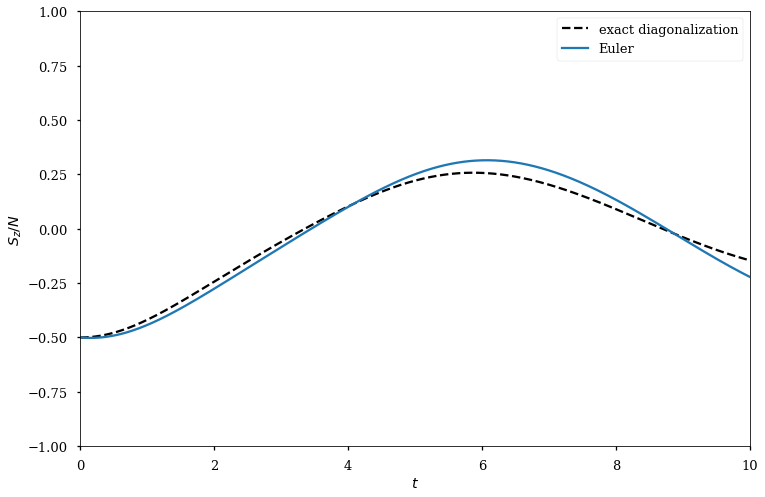

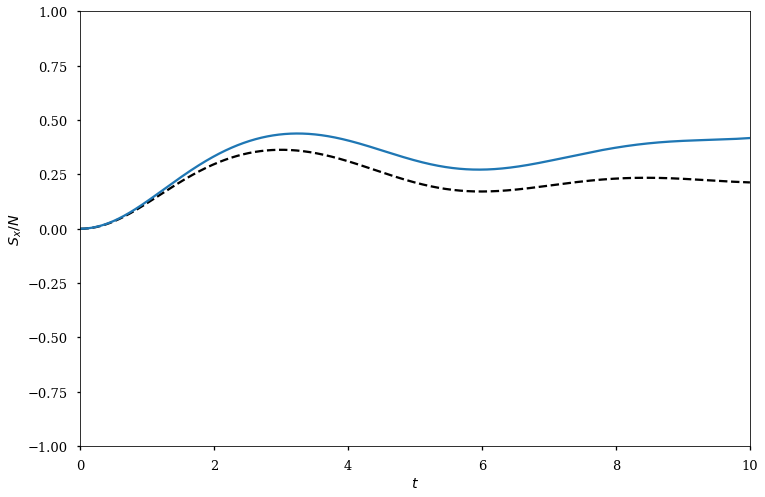

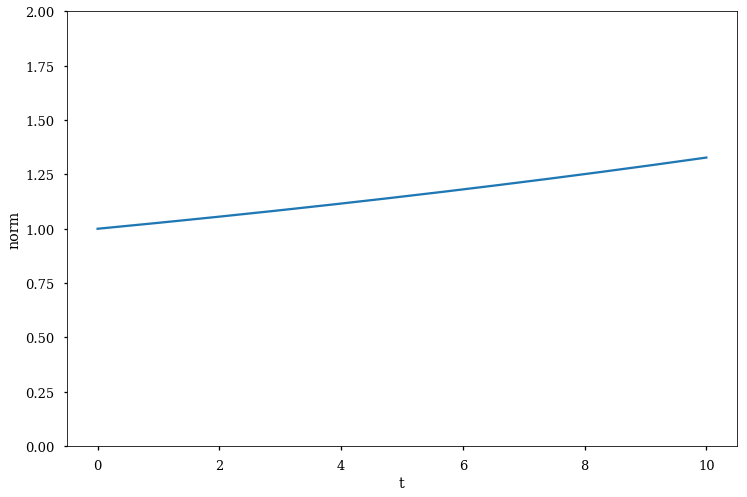

time for ED was 0.032695770263671875
Some observables have non-zero imaginary parts!! (Euler)(deviations)


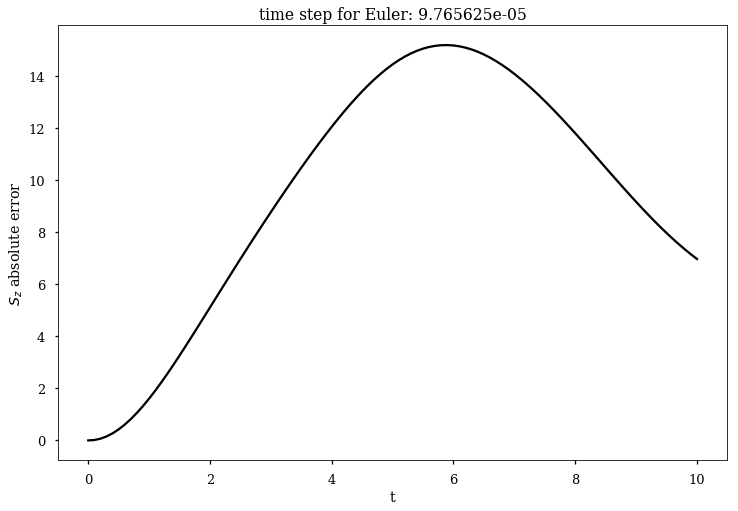

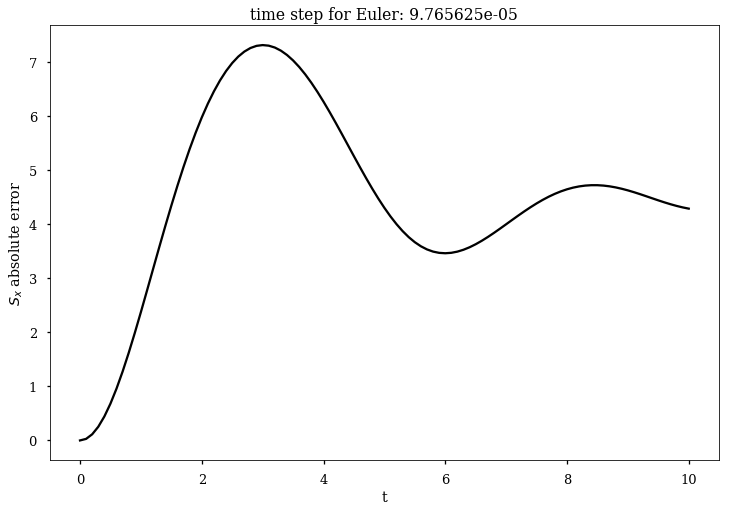

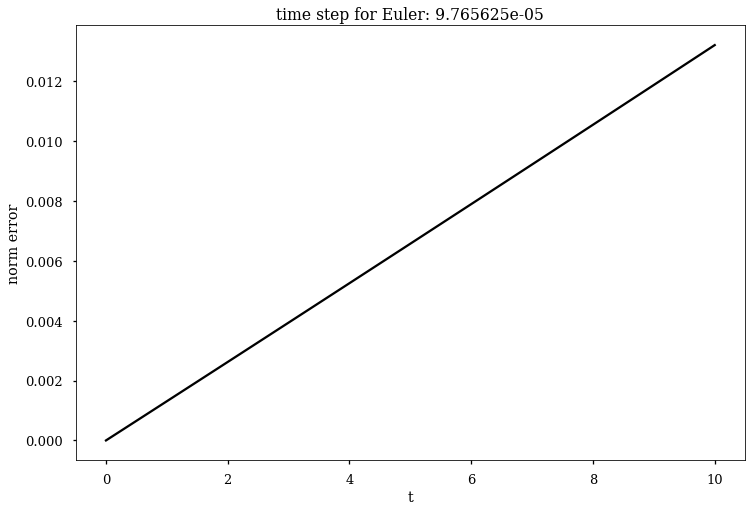

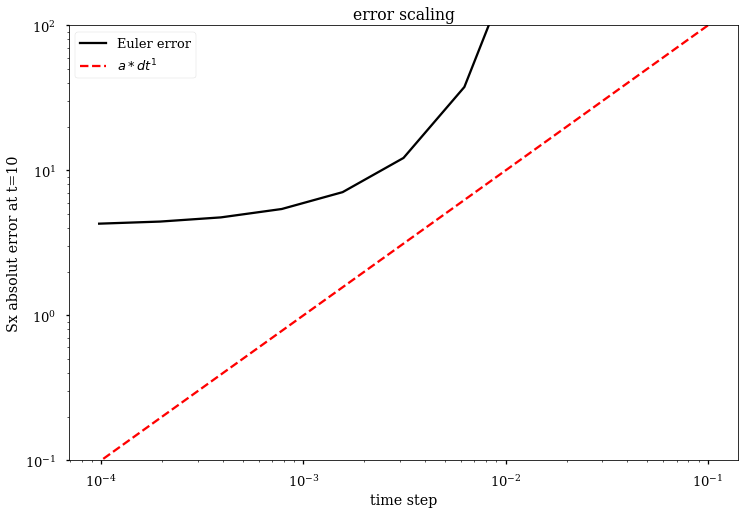

In [34]:
#Implementing the Euler integrator method
def Euler_step(y,Hmat,dt):
    return y - 1j*dt*Hmat @ y

#Initial parameters
(dt, tend, N) = (0.002, 10, 20)

#Testing Euler in comparison to ED
analysis(Euler_step, dt, tend, N)

----- Euler method for dt = 0.004 -----

time for ED was 0.47265100479125977
time for Euler was 0.618657112121582


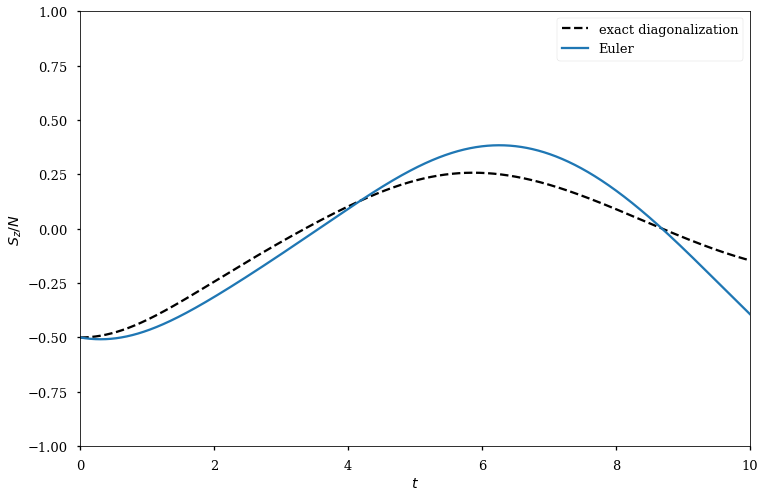

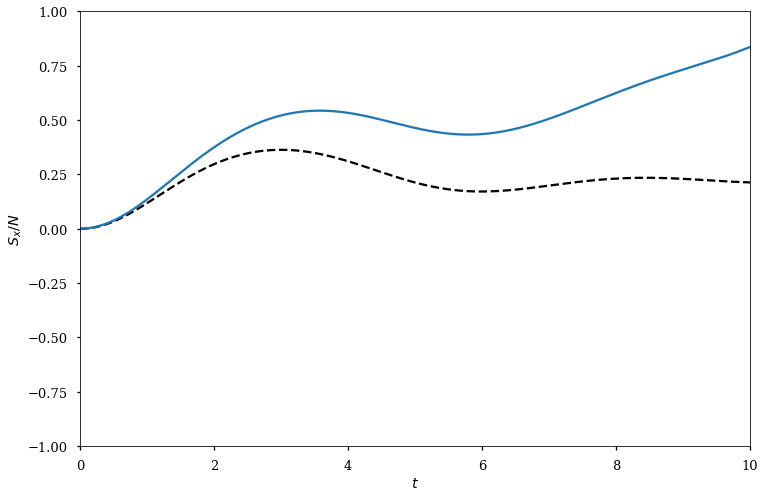

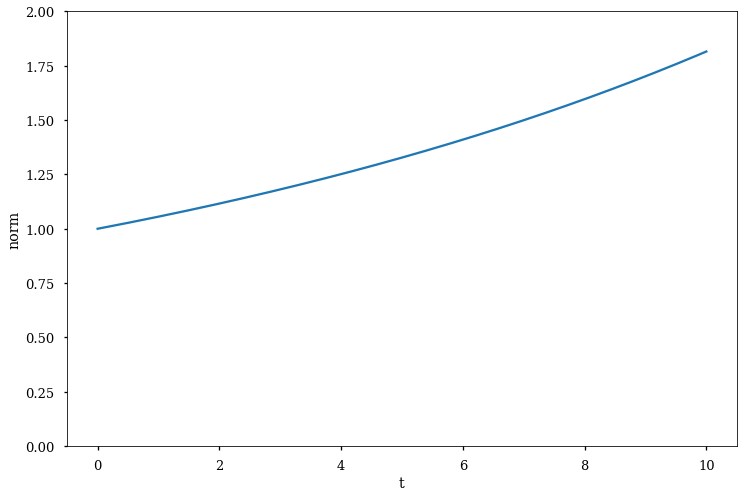

----- Euler method for dt = 0.01 -----

time for ED was 0.1871812343597412
time for Euler was 0.266340970993042


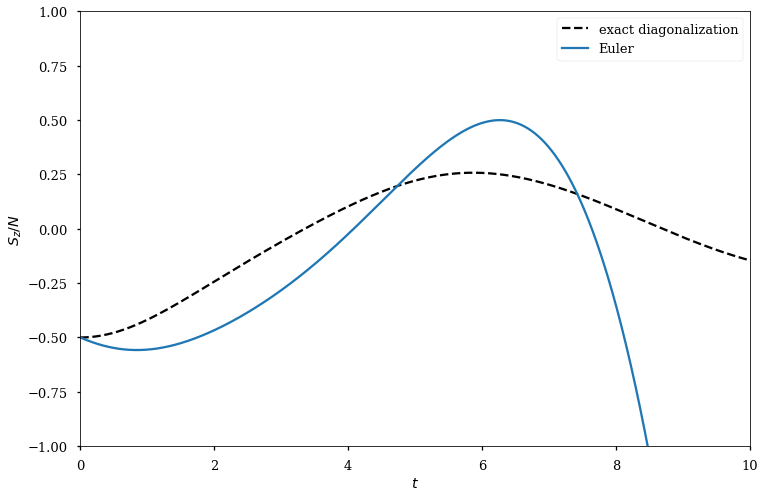

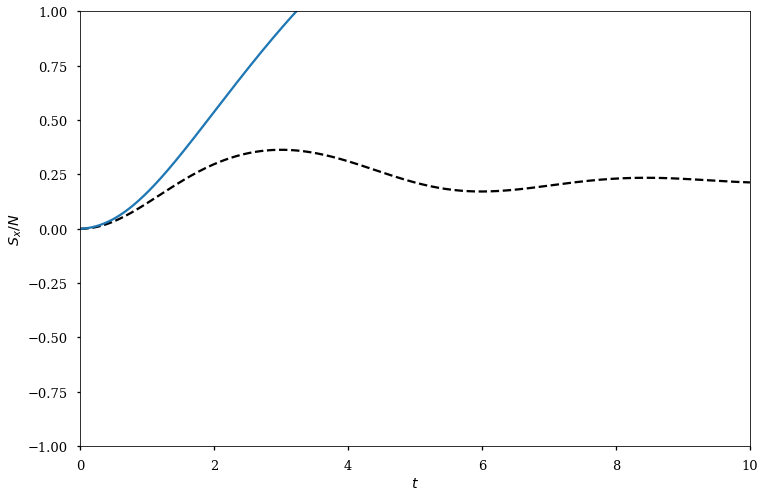

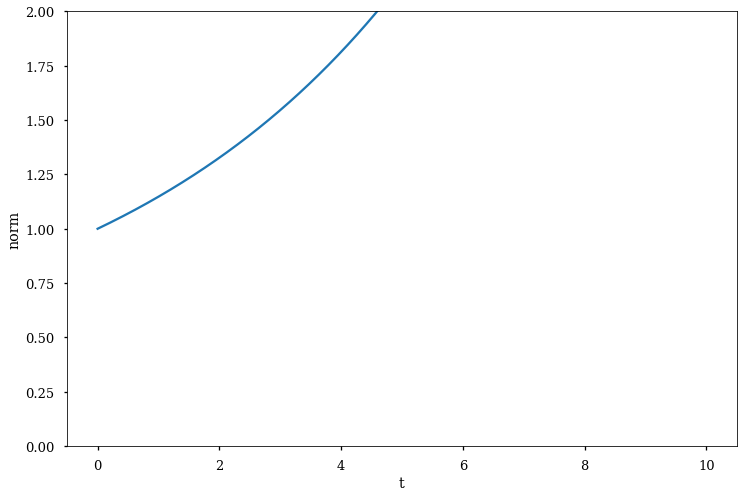

----- Euler method for dt = 0.001 -----

time for ED was 1.6701529026031494
time for Euler was 2.526381731033325


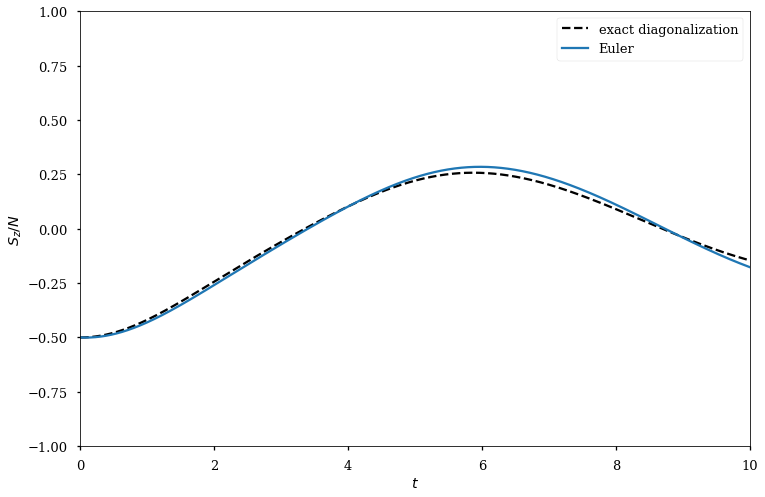

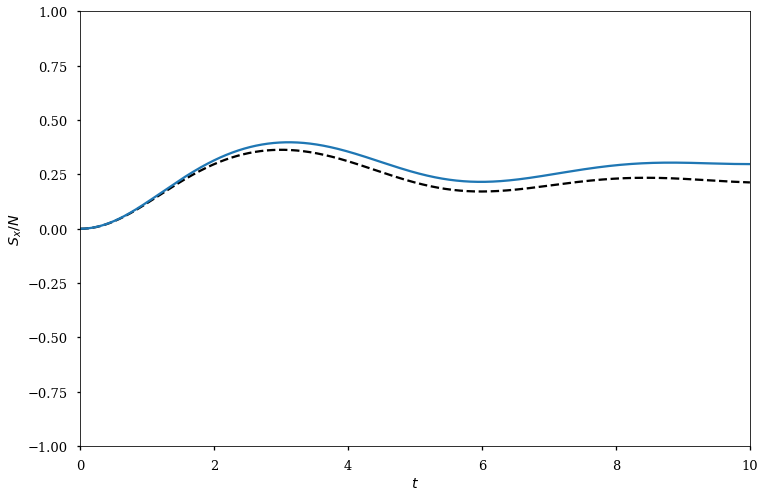

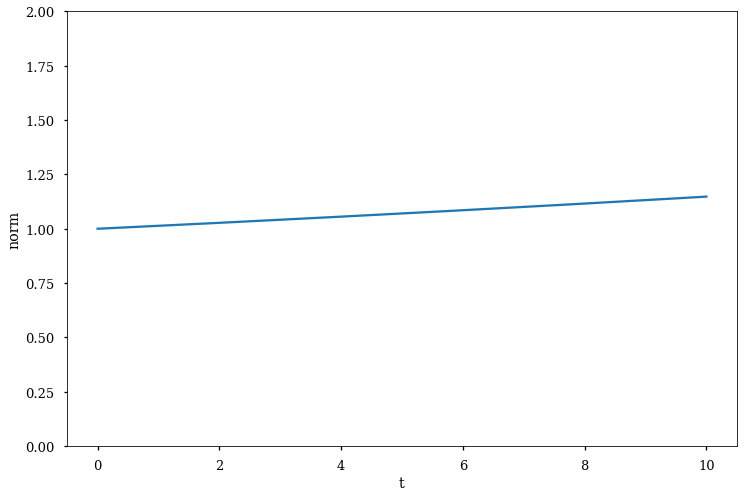

In [6]:
#some test values for dt, two larger and one smaller value
dt_test = [0.004, 0.01, 0.001]

#Plotting all to results to be able to discuss deviations
for dt_value in dt_test:
    print('----- Euler method for dt =', dt_value, '-----')
    print( )
    analysis(Euler_step, dt_value, tend, N, analyze_step_size = False)

### Discussion of our observations:

As we can easily see for the different values for dt we see dramatically different results for the diagonalization process compared to ED. <br>
The impact of a larger dt value can be observed for example if we look at the norm of $\psi$ which diverges for larger dt, whereas it stays almost stable for the last dt value which was actually smaller than the initial value. Also the accuracy compared to ED decreases a lot. <br>
Our initial choice of dt = 0.002 seems to be a good value with enough precision.

### Exercise 2 (40 points)

Do a corresponding anlysis for a second order Runge Kutta scheme (2nd order Taylor expansion of the evolution operator) and for the two-step method described in https://www5.in.tum.de/lehre/vorlesungen/wipro/ws16/folien/Askar_Explicit_Schroedinger.pdf
[equation (3.2)]. The two-step method matches the Taylor series to second order in dt, so we can use a RK2 step for initialization (to get $\psi_1$ from the initial wave function $\psi_0$).

For this case you can also go beyond $N=20$. Try at least $N=100$. With Euler, really tiny steps would be needed to prevent it from diverging in this case, but higher order integrators should do much better.

### Runge-Kutta second order

Implemeting the Runge-Kutta2 method which is based on the idea of doing a Taylor expansion up to second order.

In [7]:
def runge_kutta_2_step(Psi0,Hamiltonian, dt):
    Psi = Psi0 + (-1j*dt*Hamiltonian - 0.5*dt**2*(Hamiltonian@Hamiltonian)) @ Psi0 
    return Psi

### Two-step method

Definining the two step method presented in the paper. The first step has to be done with the RK2 method we implemented above. This step is done as part of the method we wrote for comparison in the beginning of the exercise sheet. This code only represents further steps (N > 1).

In [8]:
def two_step_method_step(Psi_1, Psi_2, Hamiltonian, dt):
    Psi = complex(0,-2)*dt*Hamiltonian*Psi_1 + Psi_2
    return Psi 

time for ED was 1.1047320365905762
time for runge_kutta_2 was 2.7298521995544434


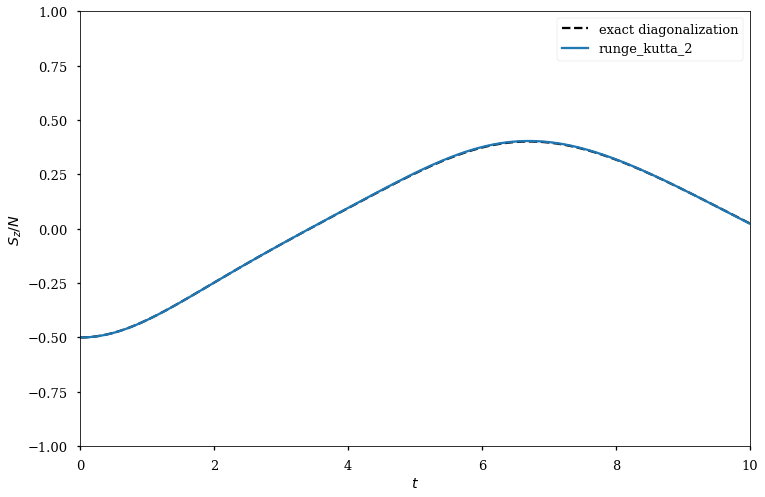

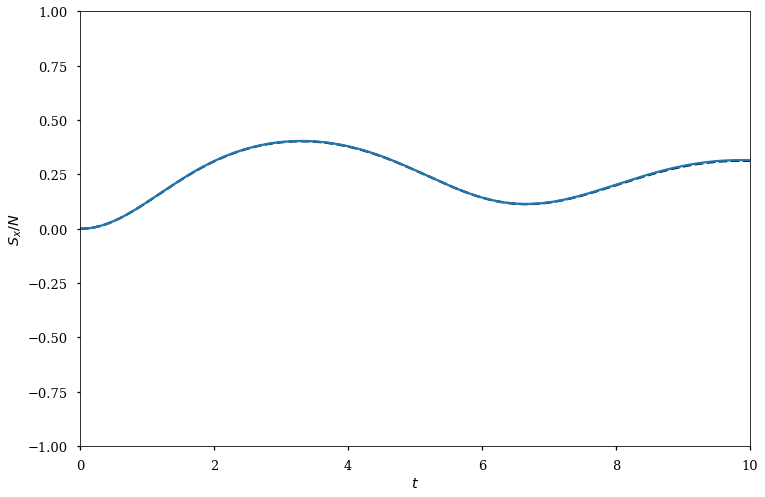

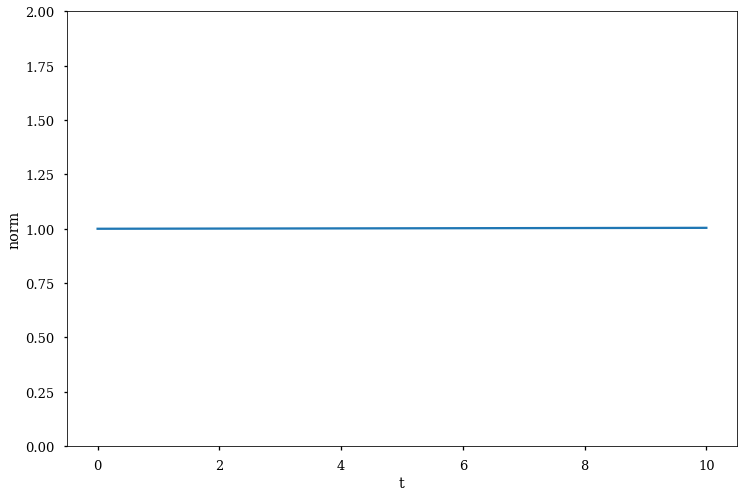

time for ED was 0.04039311408996582
Some observables have non-zero imaginary parts!! (runge_kutta_2)(deviations)


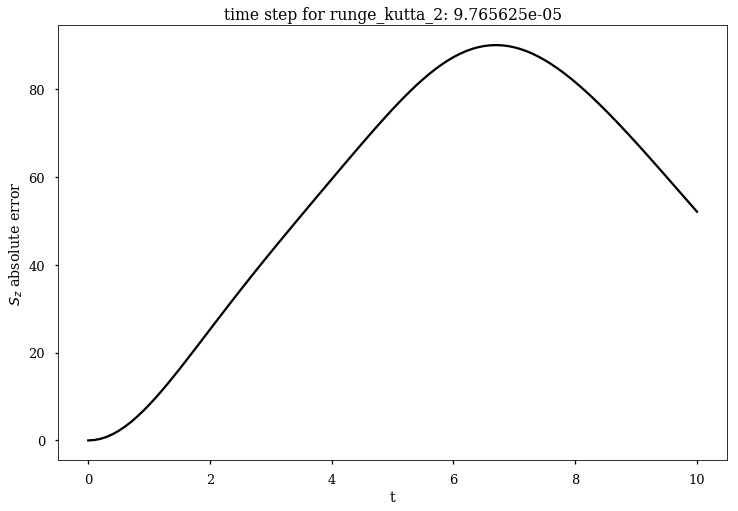

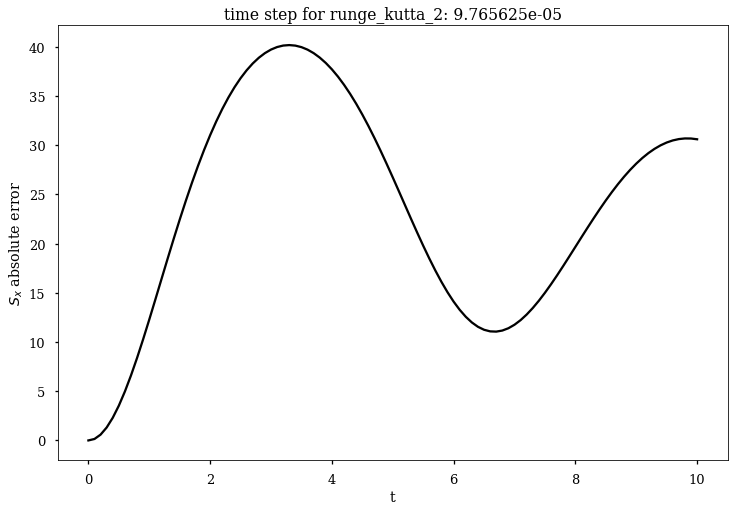

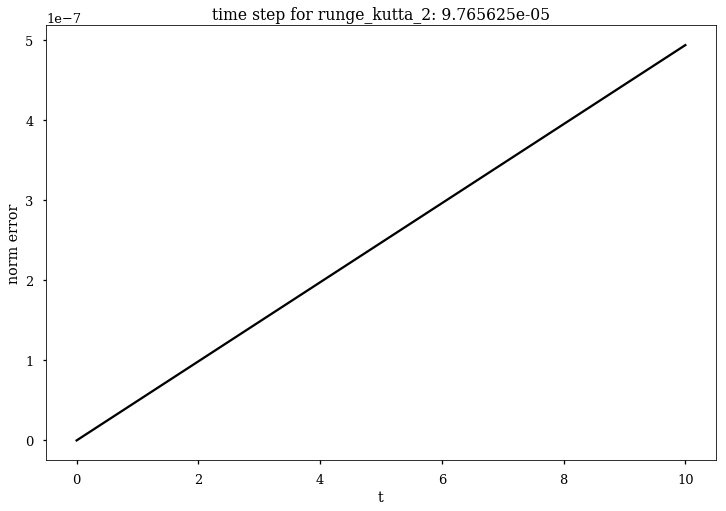

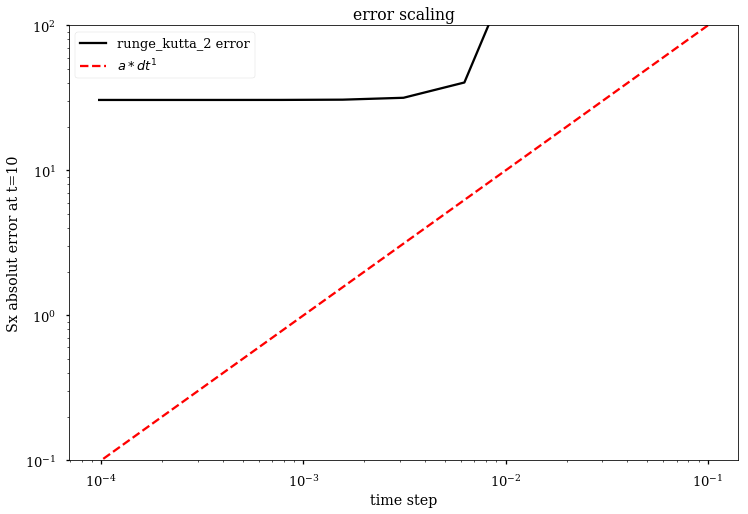

time for ED was 1.02229905128479
time for two_step_method was 1.2132718563079834


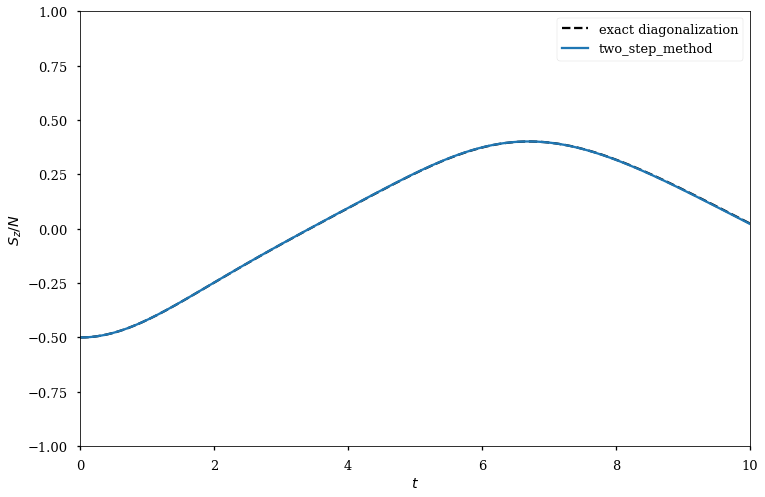

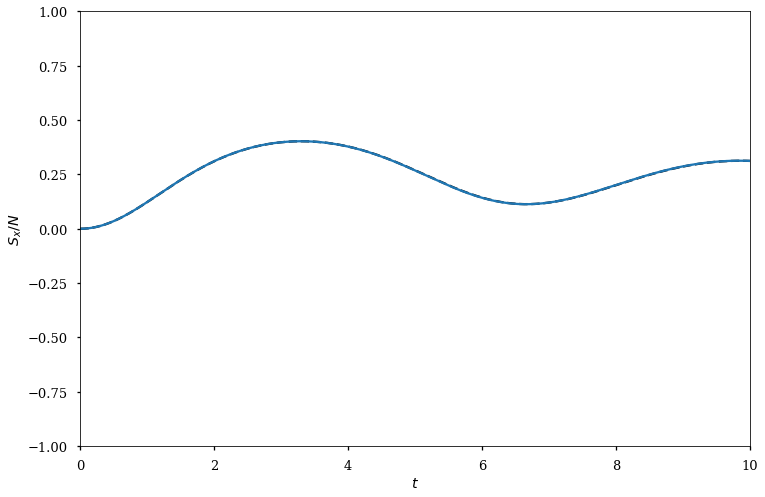

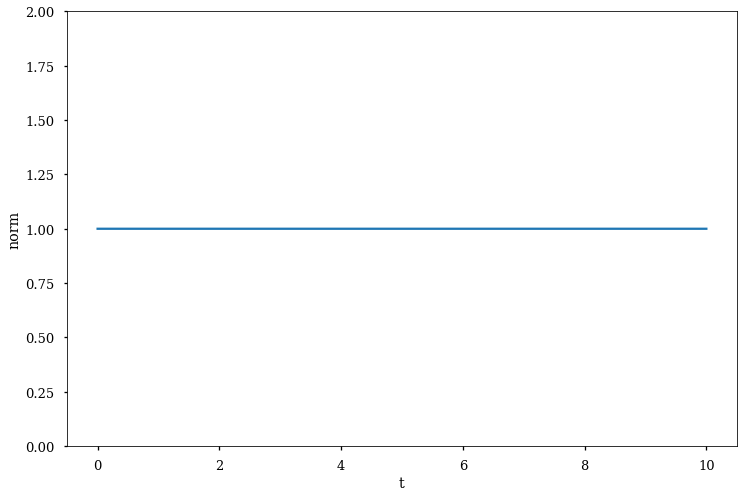

time for ED was 0.025753021240234375
Some observables have non-zero imaginary parts!! (two_step_method)(deviations)


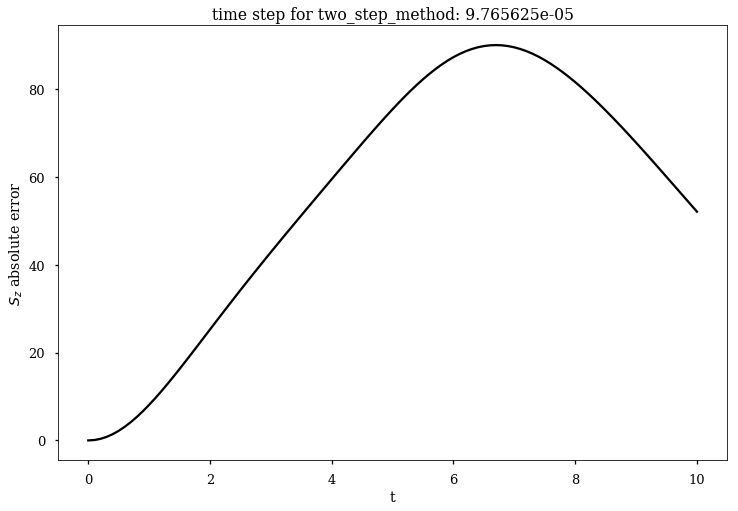

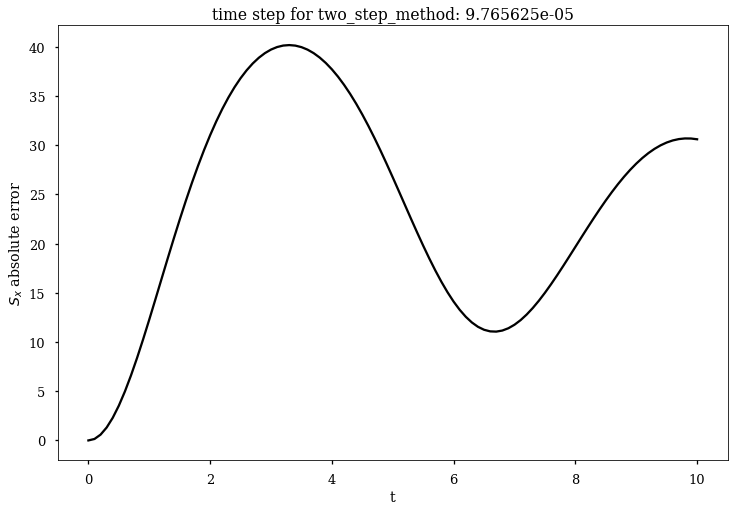

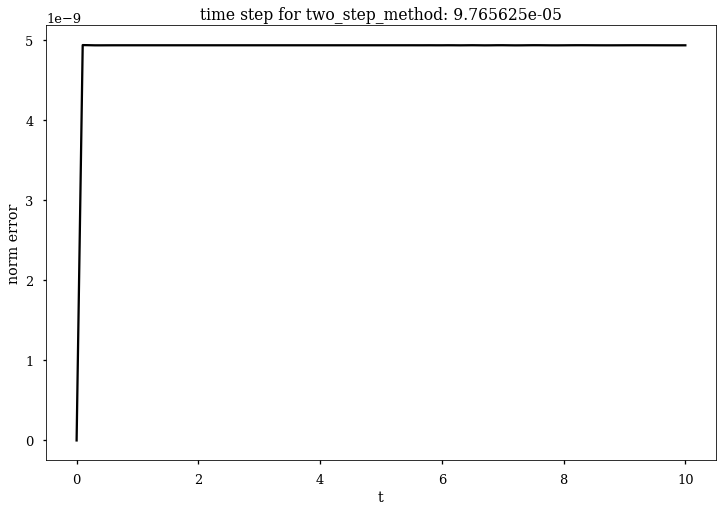

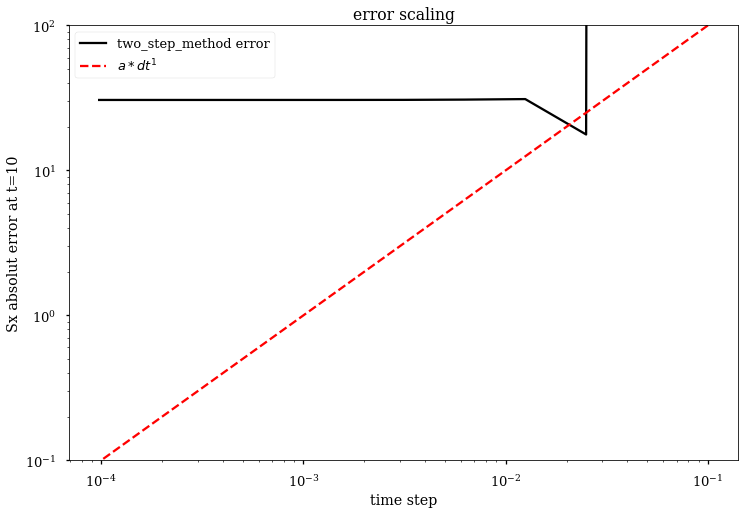

In [18]:
#initial values
(dt, tend, N) = (0.002, 10, 100)

#Our implemented methods
self_impl = [runge_kutta_2_step, two_step_method_step]

#This part took about 110s of computing time on my laptop
for method in self_impl:
    analysis(method, dt, tend, N)

#### Varying dt for the RK2:

----- RK2 method for dt = 0.004 -----

time for ED was 0.5746030807495117
time for runge_kutta_2 was 1.9560539722442627


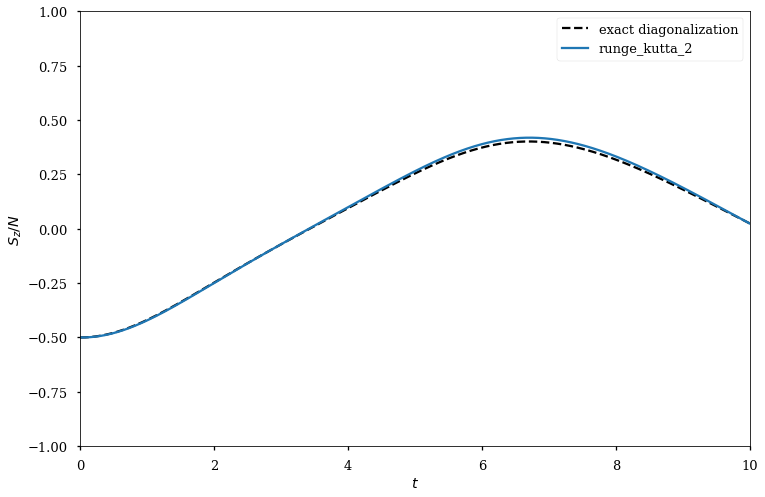

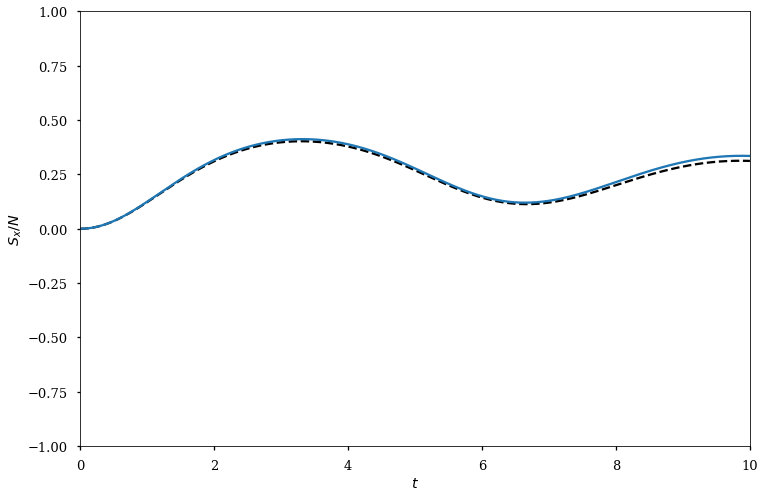

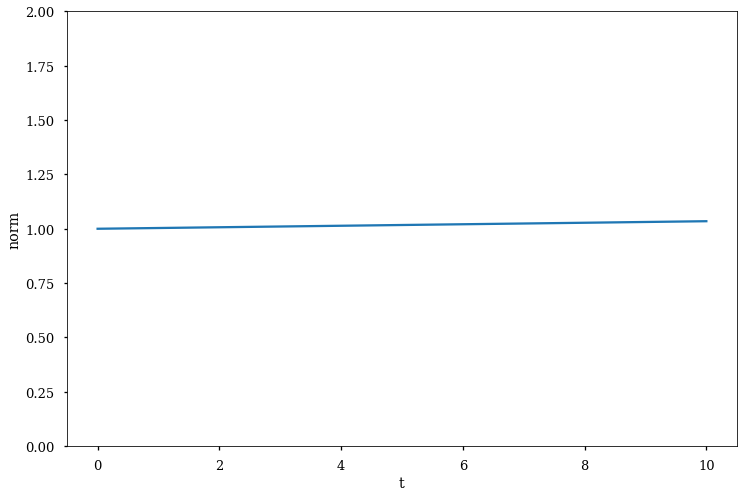

----- RK2 method for dt = 0.01 -----

time for ED was 0.3950488567352295
time for runge_kutta_2 was 0.6472446918487549


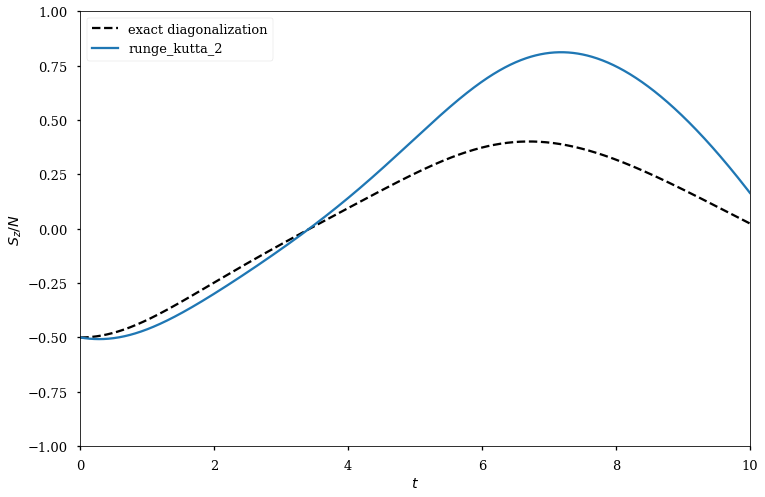

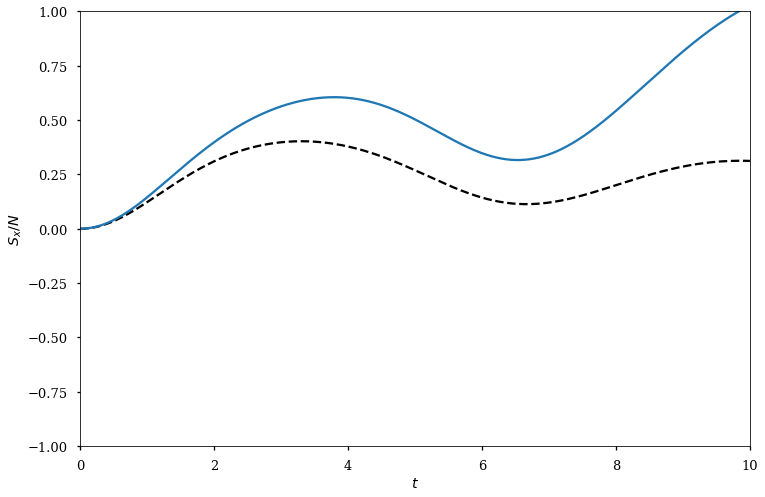

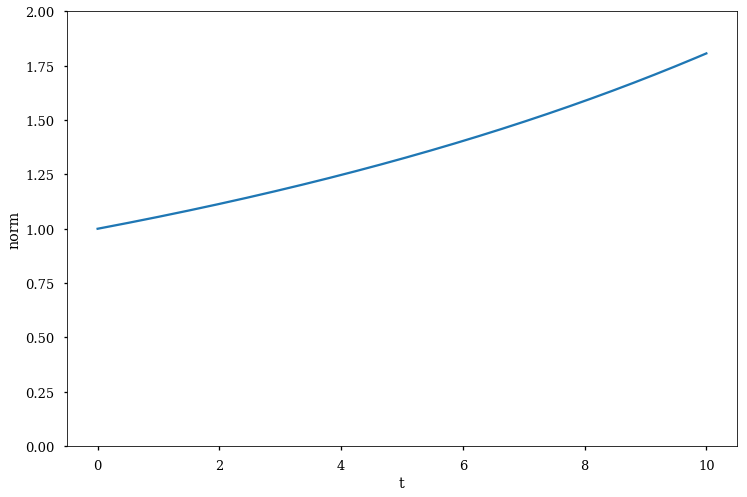

----- RK2 method for dt = 0.001 -----

time for ED was 4.1095240116119385
time for runge_kutta_2 was 9.678783893585205


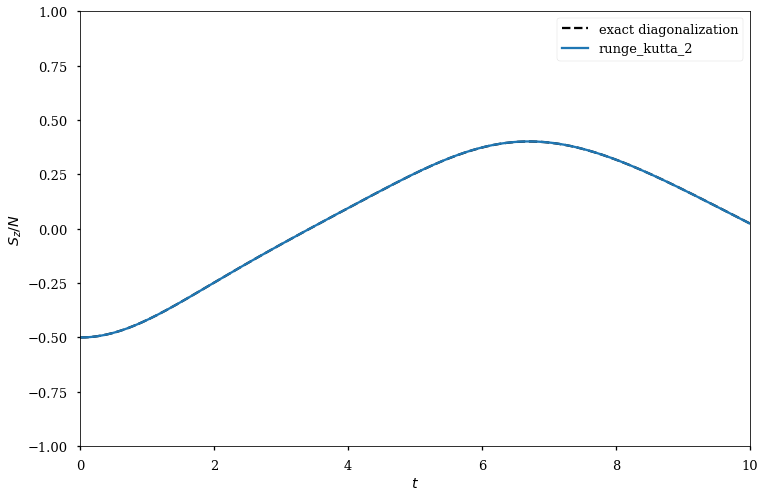

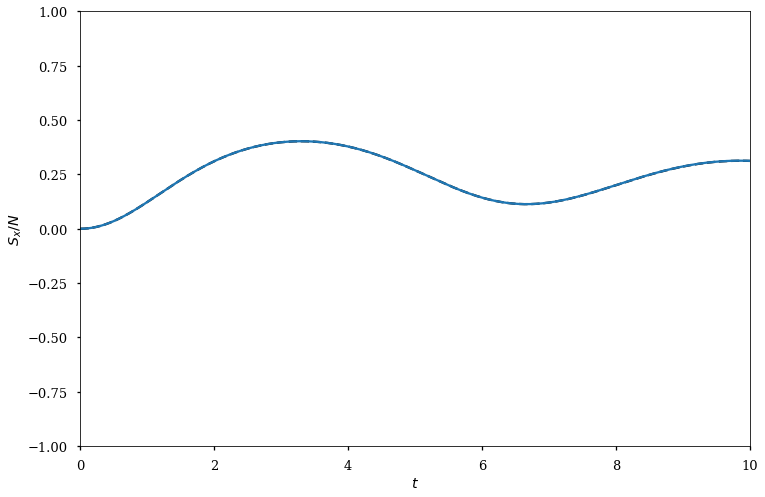

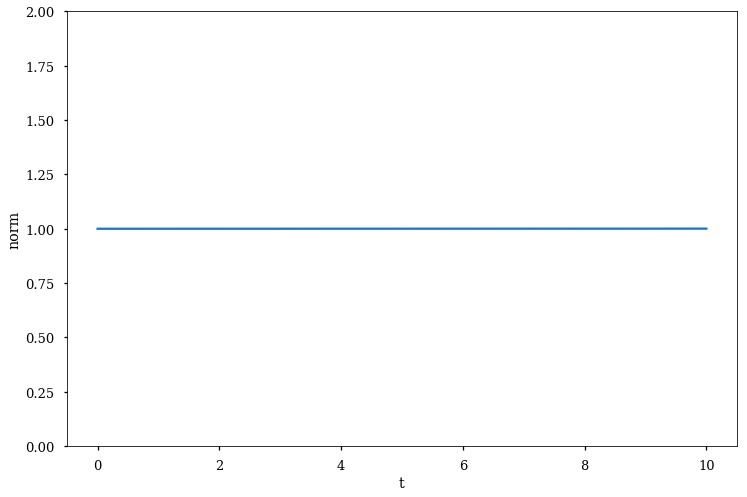

In [19]:
for dt_value in dt_test:
    print('----- RK2 method for dt =', dt_value, '-----')
    print( )
    analysis(runge_kutta_2_step, dt_value, tend, N, analyze_step_size = False)

#### Varying dt for the two-step method:

----- Two-step method for dt = 0.004 -----

time for ED was 0.5728511810302734
time for two_step_method was 0.6209619045257568


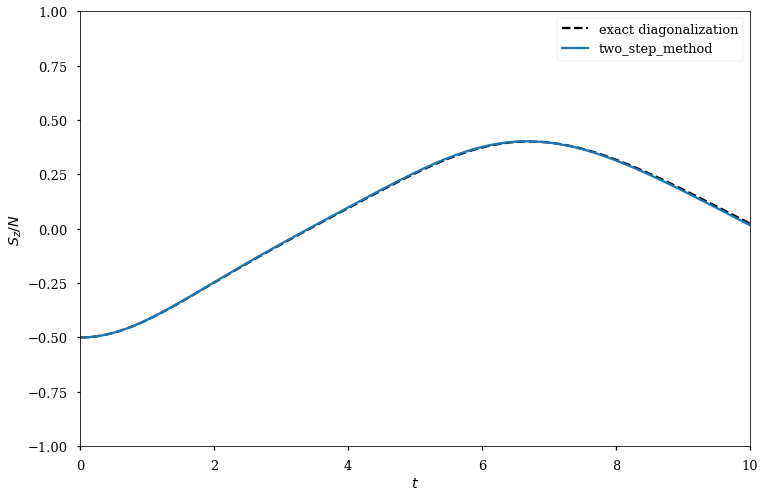

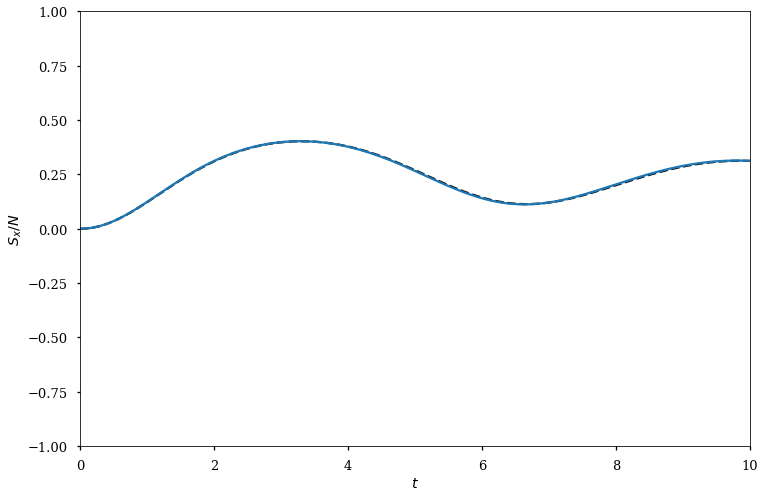

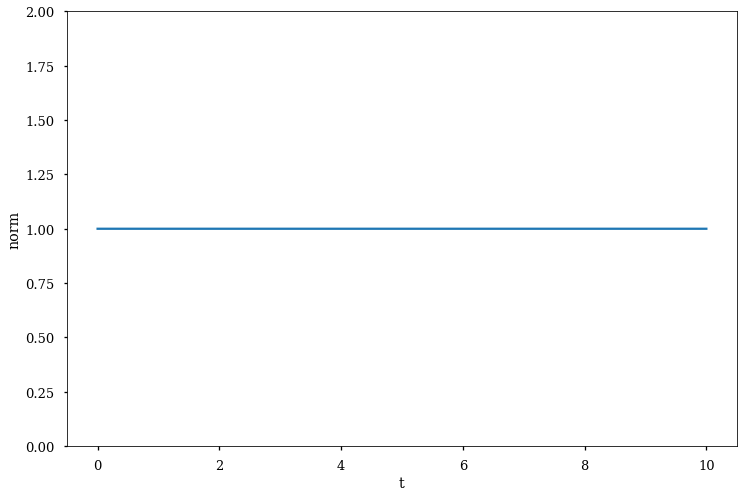

----- Two-step method for dt = 0.01 -----

time for ED was 0.4405941963195801
time for two_step_method was 0.40154075622558594


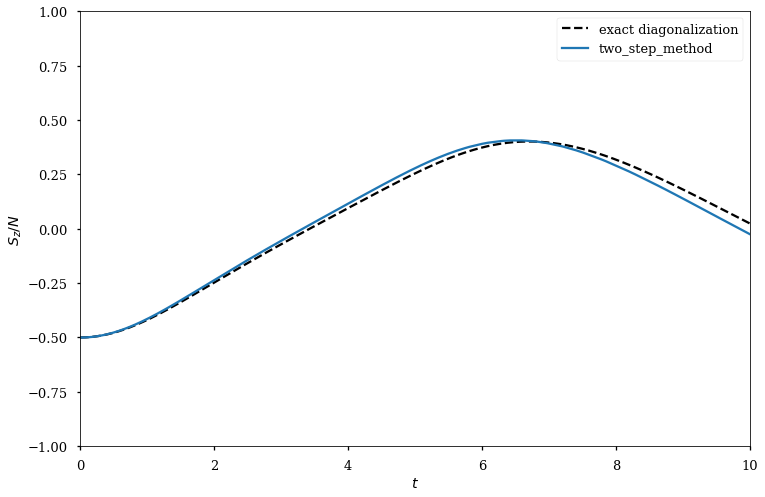

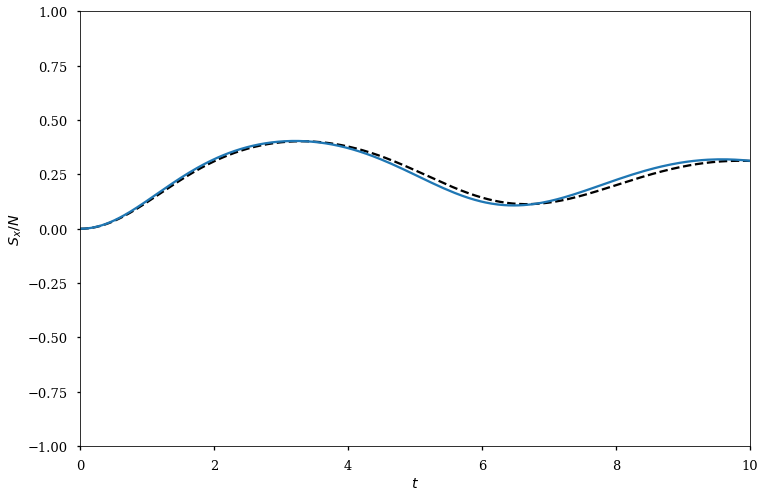

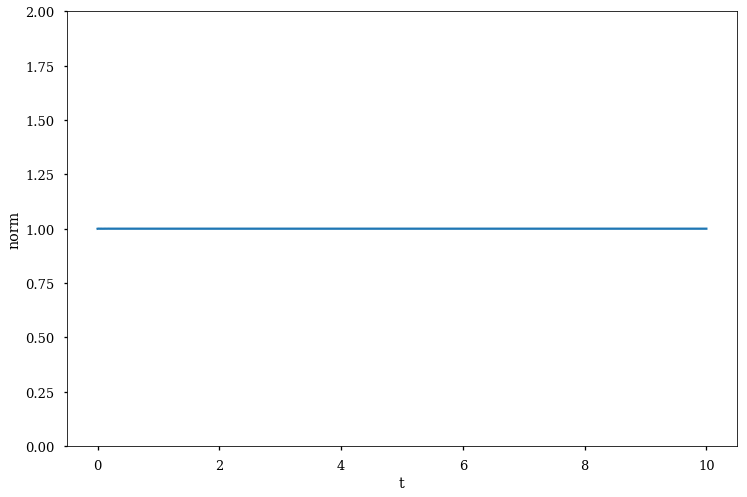

----- Two-step method for dt = 0.001 -----

time for ED was 2.161606788635254
time for two_step_method was 2.4325382709503174


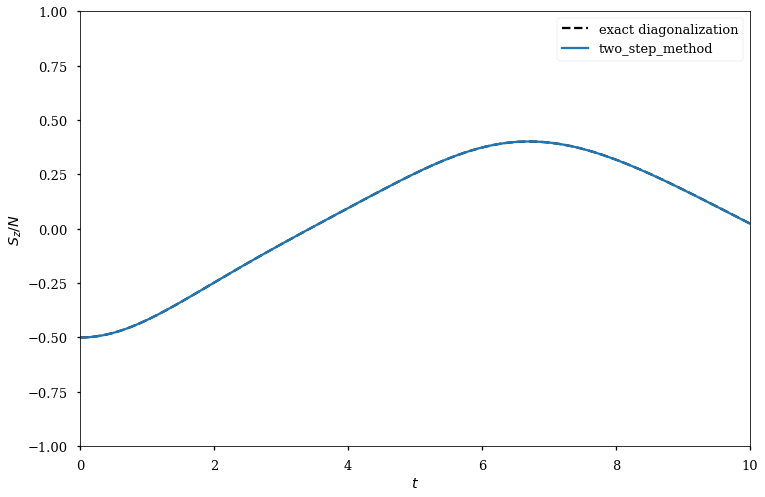

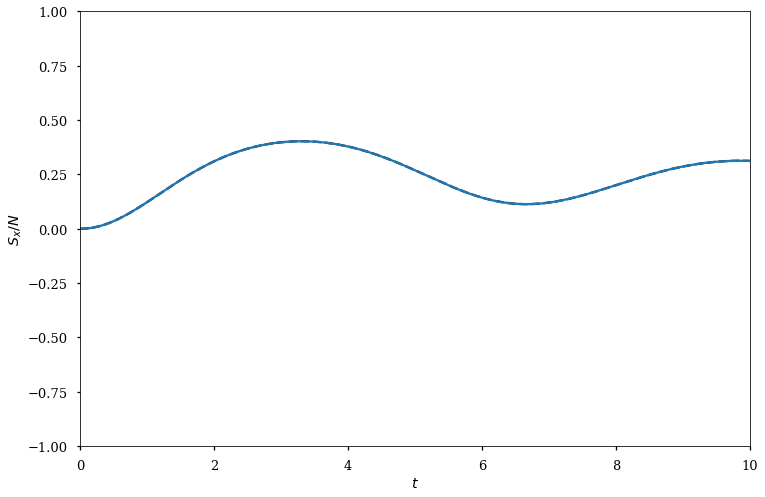

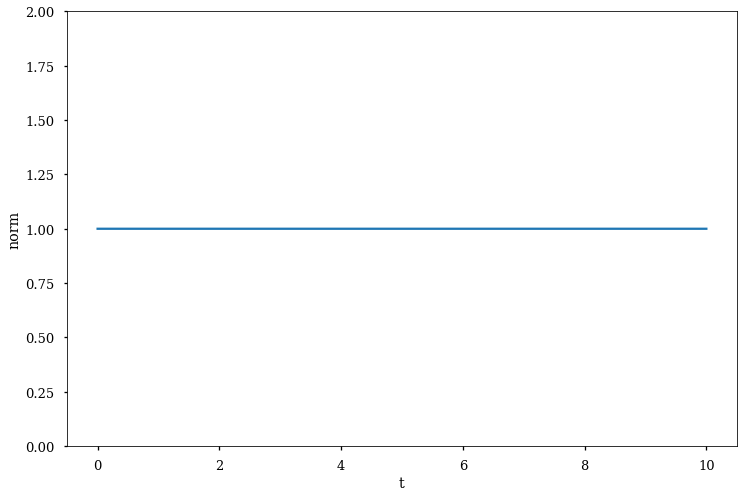

In [20]:
for dt_value in dt_test:
    print('----- Two-step method for dt =', dt_value, '-----')
    print( )
    analysis(two_step_method_step, dt_value, tend, N, analyze_step_size = False)

### Discussion of our observations:
Now we are able to analyze the situation for larger $N$, i.e. $N=100.$

#### RK2

As we can see in the first set of plots, the norm again diverges for larger step sizes but nevertheless the accuracy of the solution is a lot better compared to the Euler method. The error increases rapidly for ,larger dt as we already observe for the initial step size.

#### Two-Step method

This method seems to be pretty stable, also for larger step sizes. The norm is constant for all the dt values we chose. But for even larger step sizes the error should also increase rapidly as we can see in the last plot of the first analysis with the initial parameters.

### Exercise 3 (25 points)

Now we want to use a numerical intergrator from the scipy.integrate module. For this I reccomend using the "ode" class which gives the best control of parameters and greatest choice of methods. The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

Try different integrators and options. Use a fixed particle number of N=100. Describe your observations. For me, the options that worked best are given as an example below. If you find something faster/mor stable, let me know!

These integrators all use adaptive stepsize internally, so we don't have to analyze the step size dependence of the accuracy. They should in principle always give accurate results or otherwise give a warning message that the specified accuracy goal could not be reached.

In [10]:
#Using a scipy out-of-the-box integrator
from scipy.integrate import ode
from scipy.integrate import complex_ode

def f(t, y):
    return -1j*Hmat @ y # RHS of the SE

In [38]:
#New initial parameters
(dt, tend, N) = (0.002, 10 , 100)

#Setting up some of the scipy integrators
scipy_integrators= [complex_ode(f).set_integrator('vode', method='adams'),
                    complex_ode(f).set_integrator('vode', method='bdf'),
                    ode(f).set_integrator('zvode', method='adams'),
                    ode(f).set_integrator('zvode', method='bdf'),
                    complex_ode(f).set_integrator('lsoda'),
                    complex_ode(f).set_integrator('dopri5'),
                    complex_ode(f).set_integrator('dop853')]
    
#building the Hamiltonian because complex_ode has a bug and can't handle function arguments
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

dim = N+1
ini = np.eye(1,dim,0)[0]
Sz = buildSz(N)
Sx = buildSx(N)
Sz2 = Sz @ Sz
Hmat = buildH(N,omega)

time for ED was 1.7262160778045654
time for vode was 1.5352001190185547


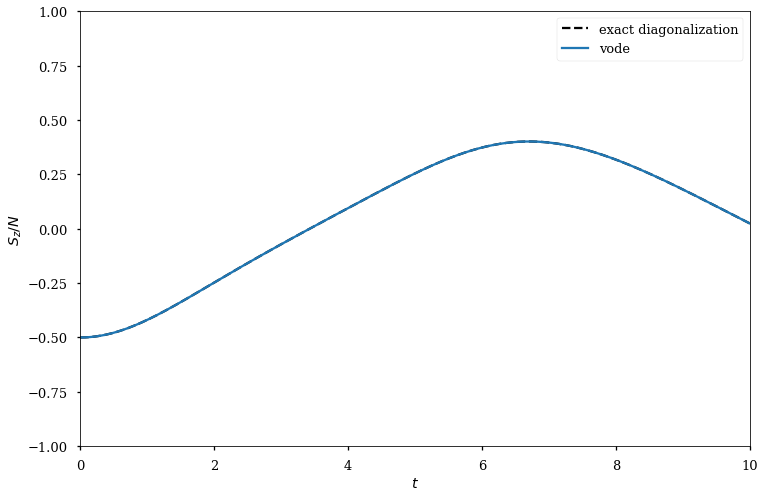

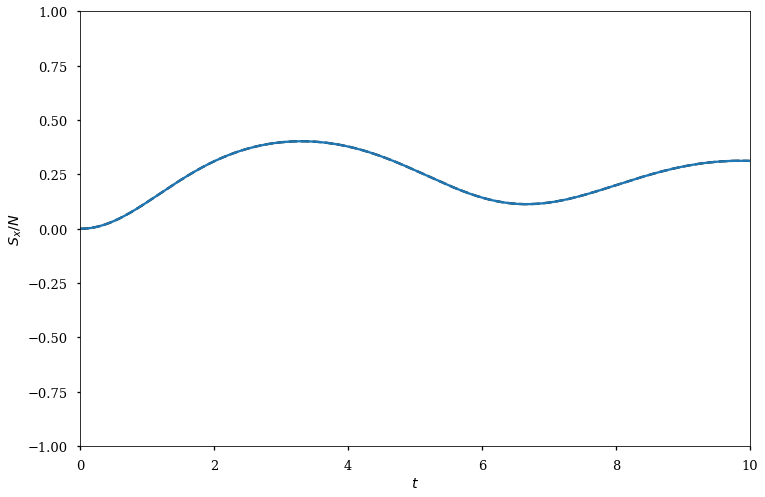

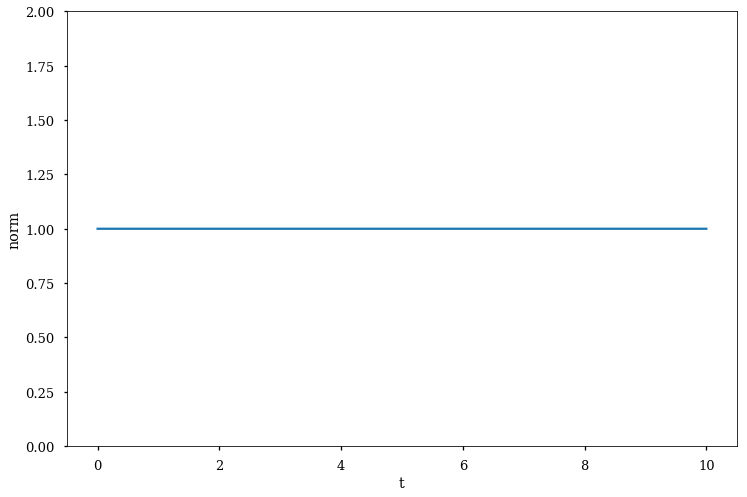

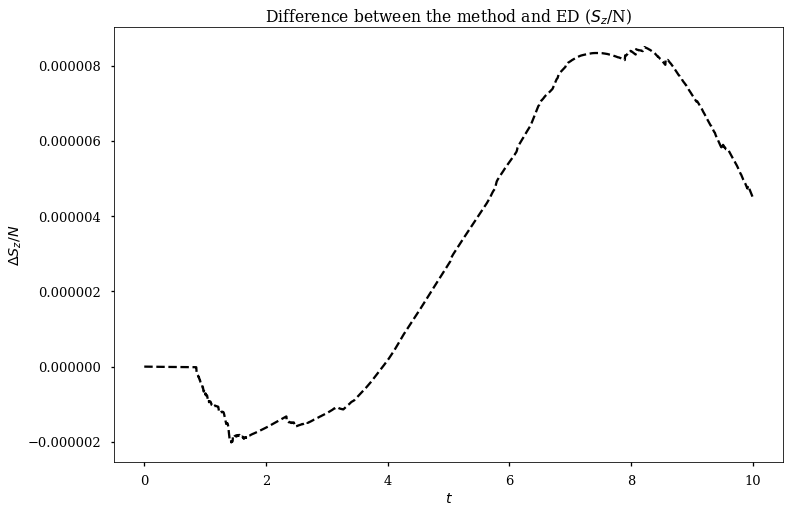

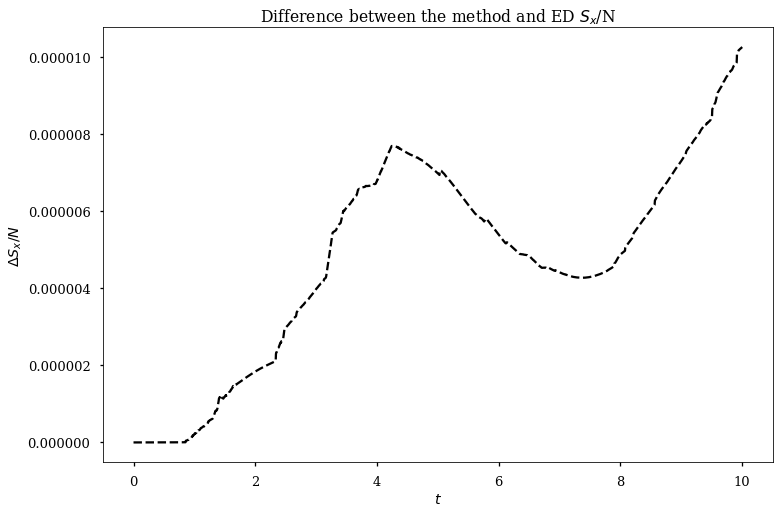

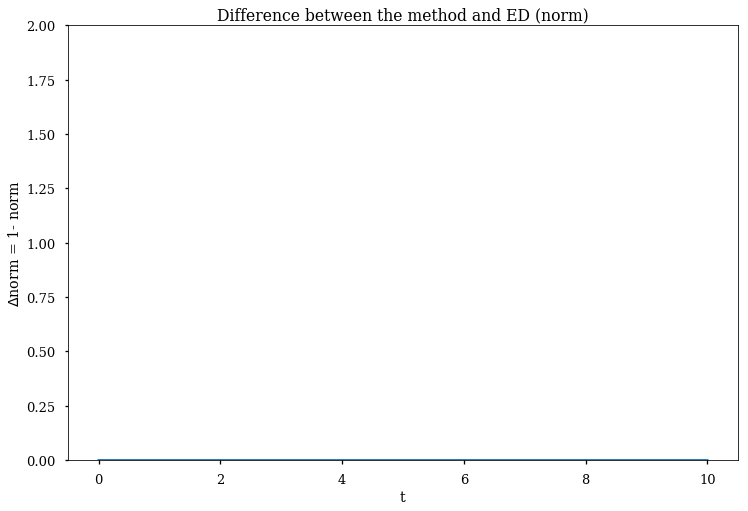

---------------------------------

time for ED was 1.133005142211914
time for vode was 1.6591970920562744


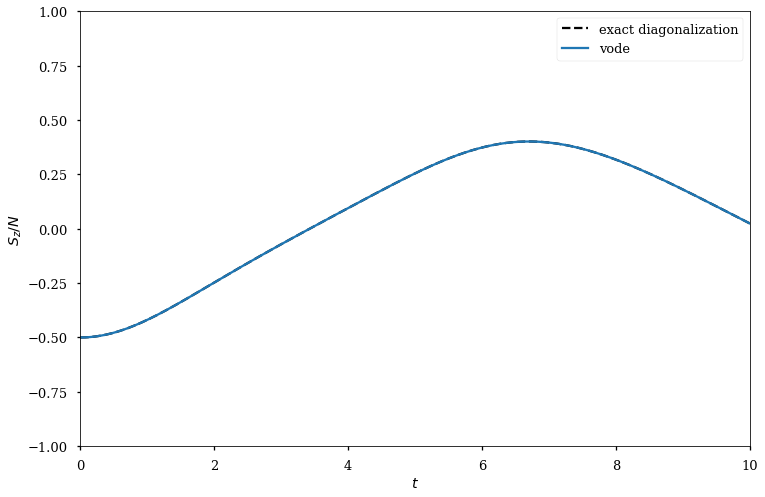

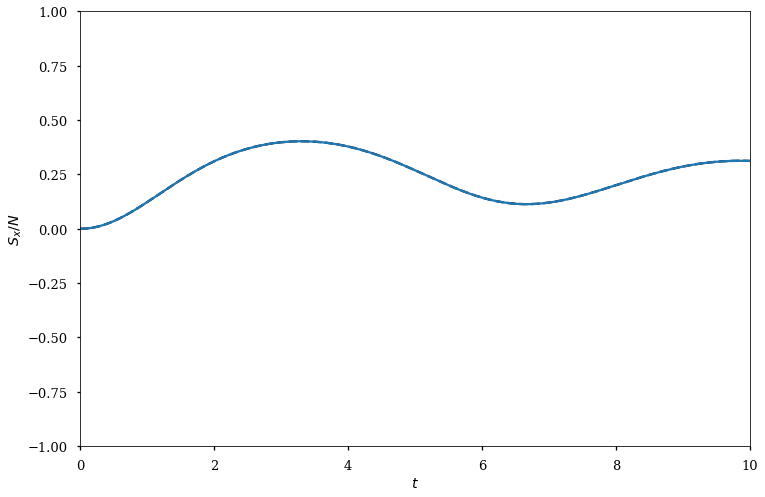

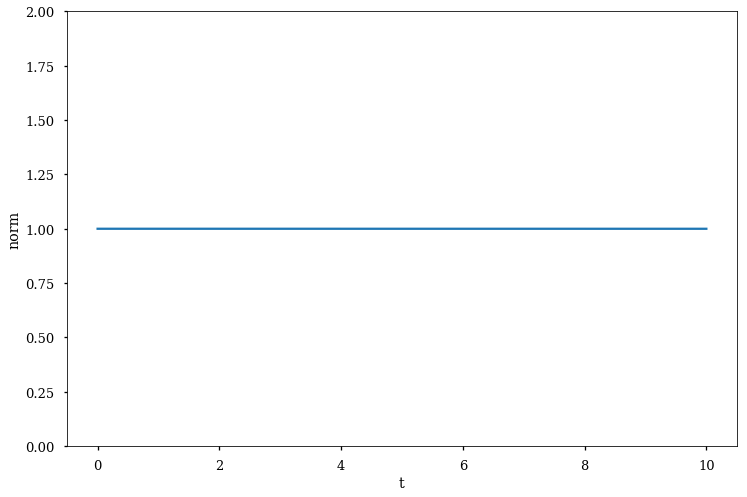

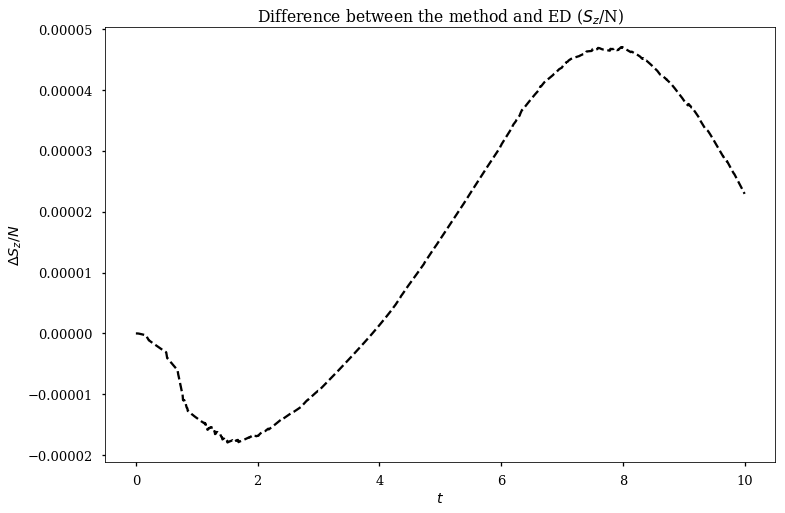

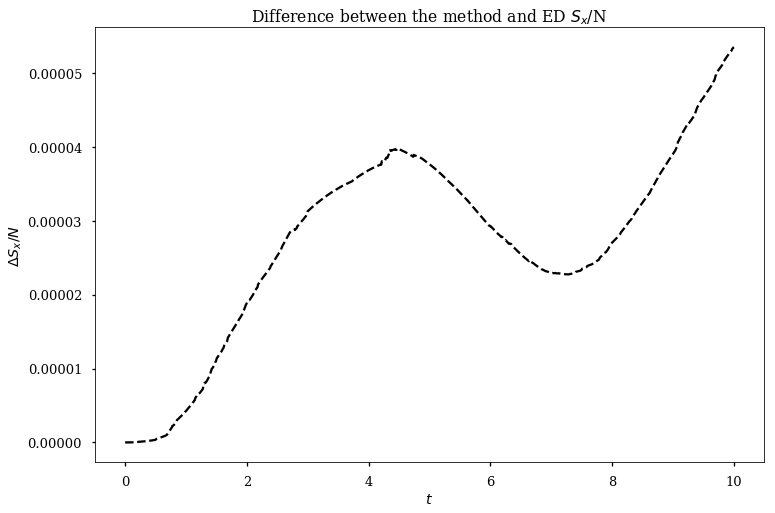

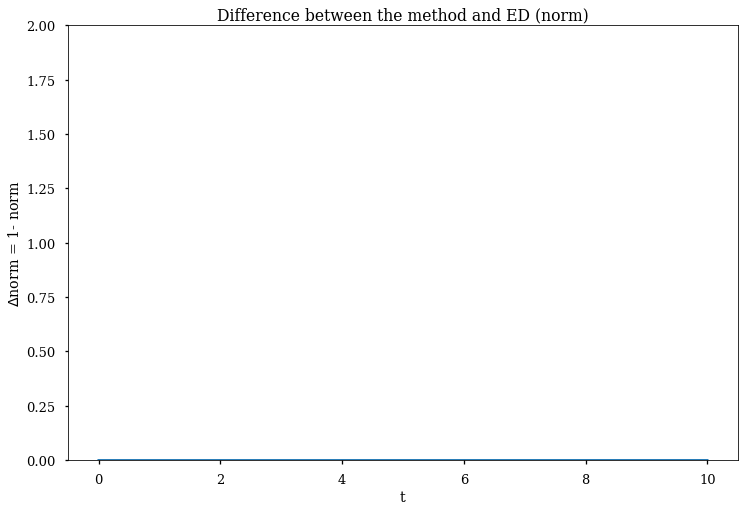

---------------------------------

time for ED was 1.093337059020996
time for zvode was 1.377223014831543


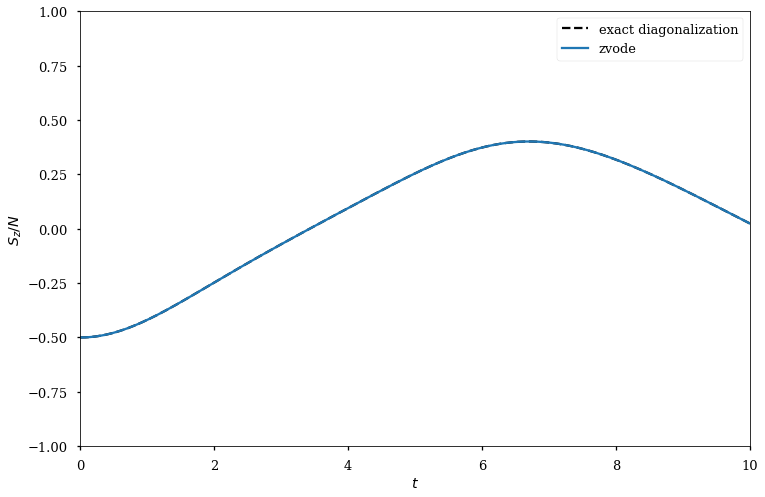

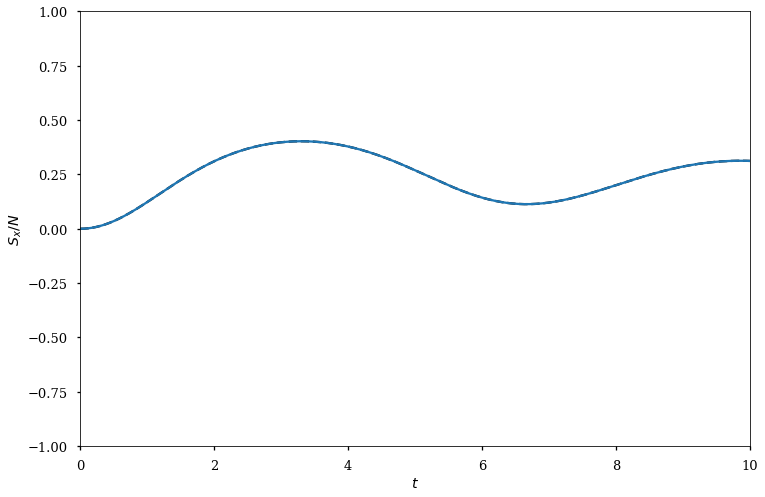

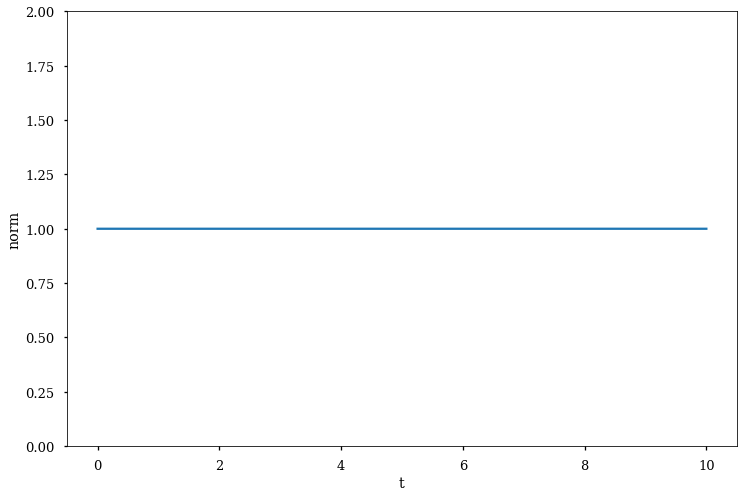

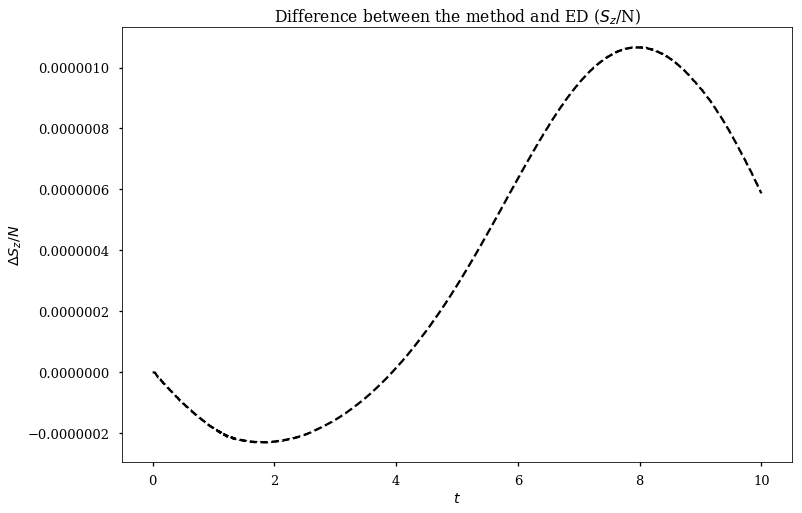

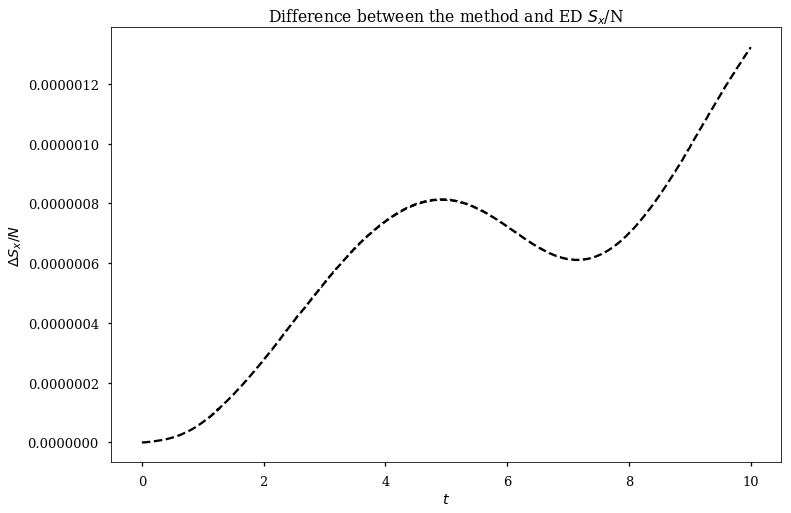

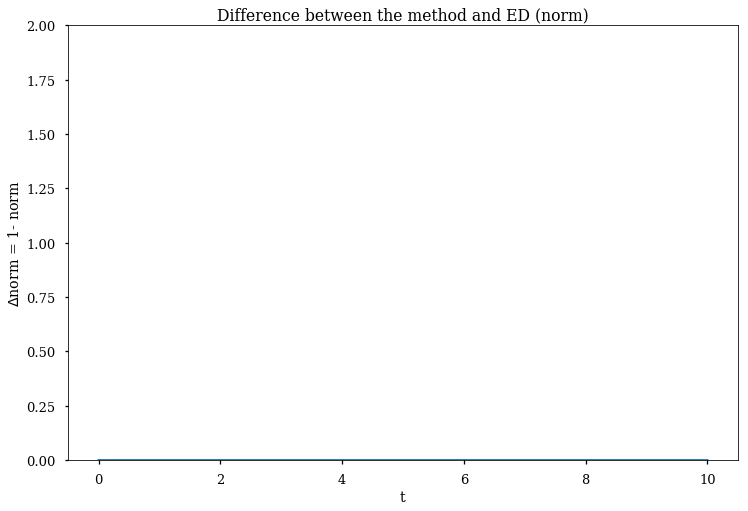

---------------------------------

time for ED was 1.7573001384735107
time for zvode was 1.8124358654022217


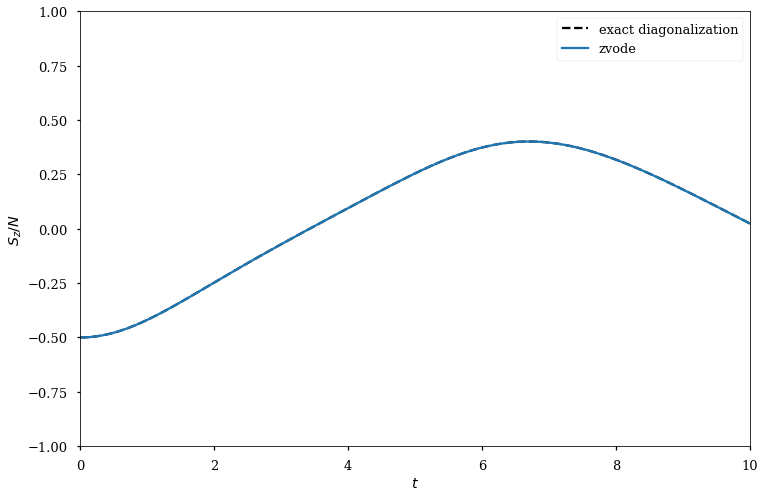

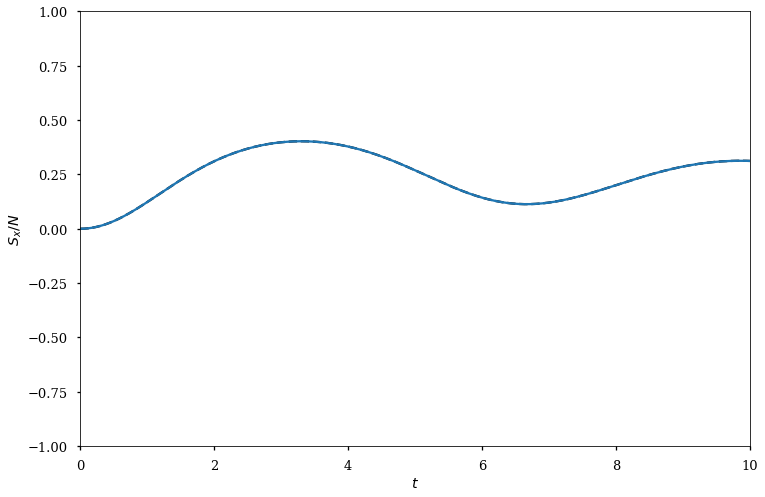

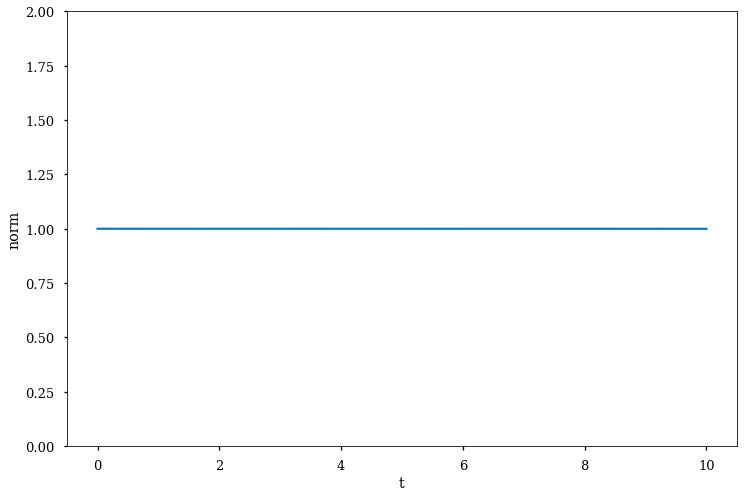

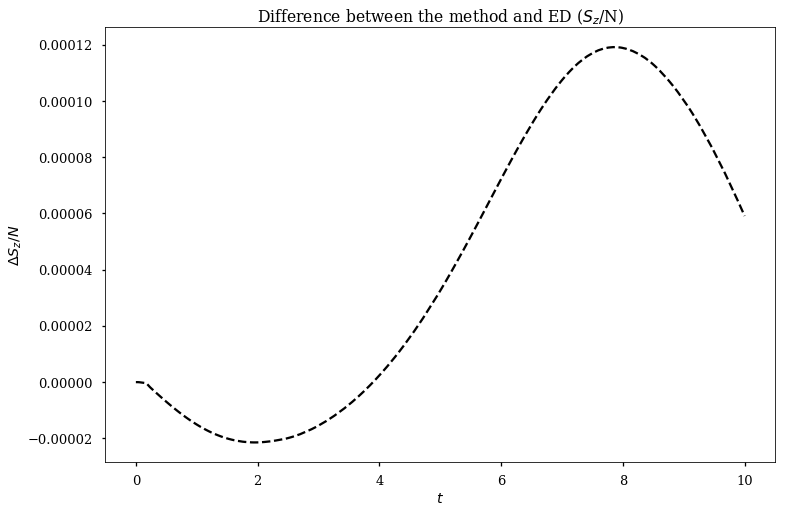

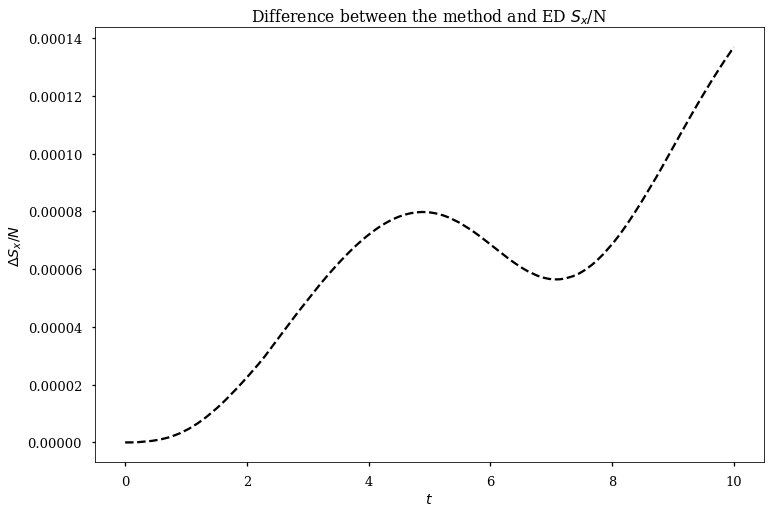

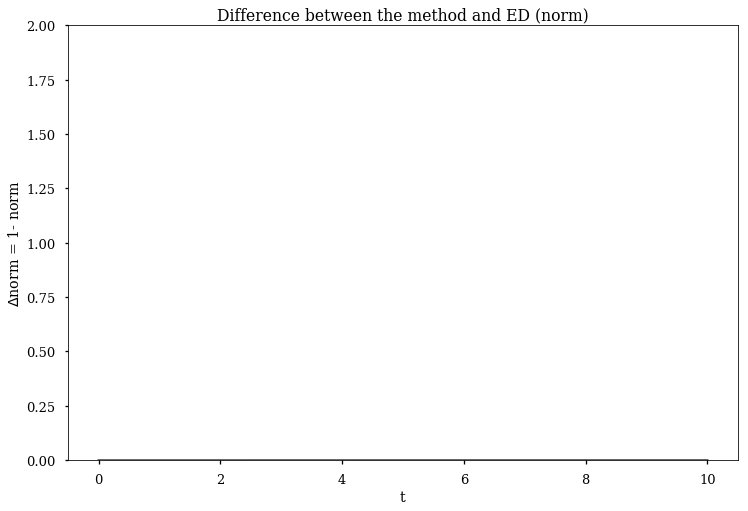

---------------------------------

time for ED was 1.4107491970062256
time for lsoda was 25.54043173789978


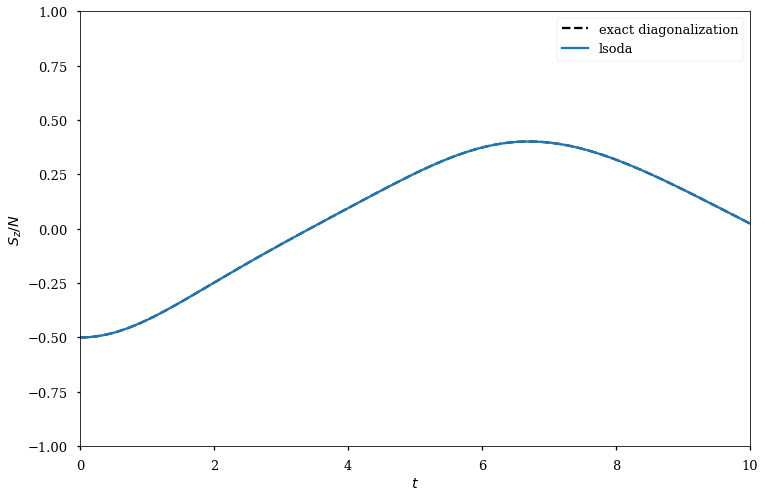

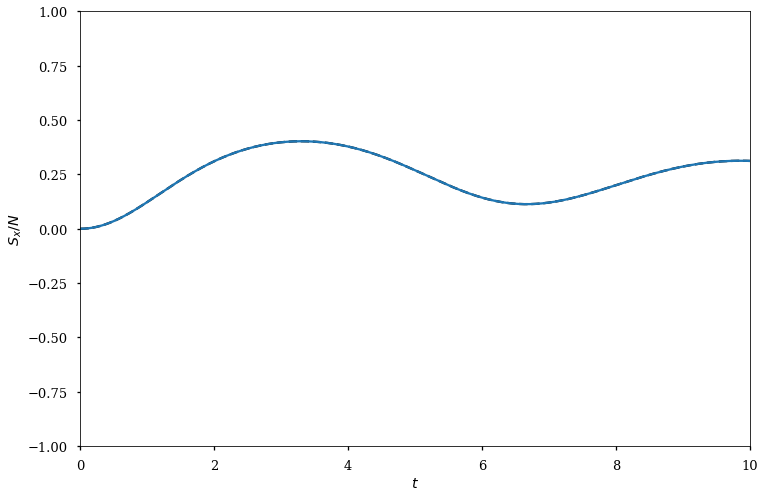

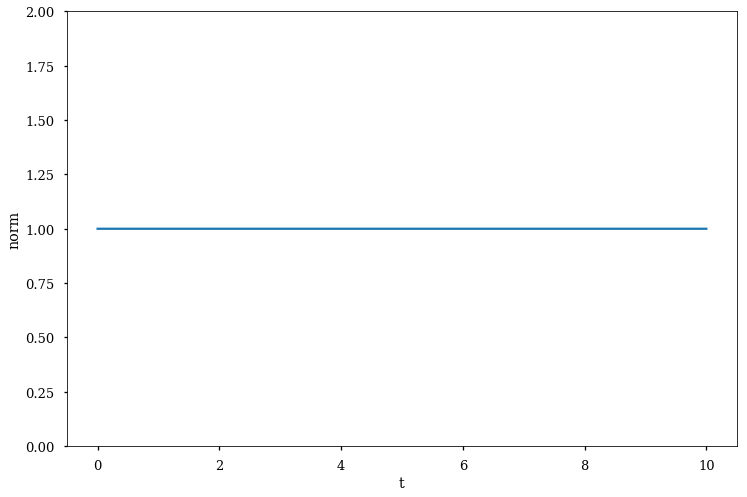

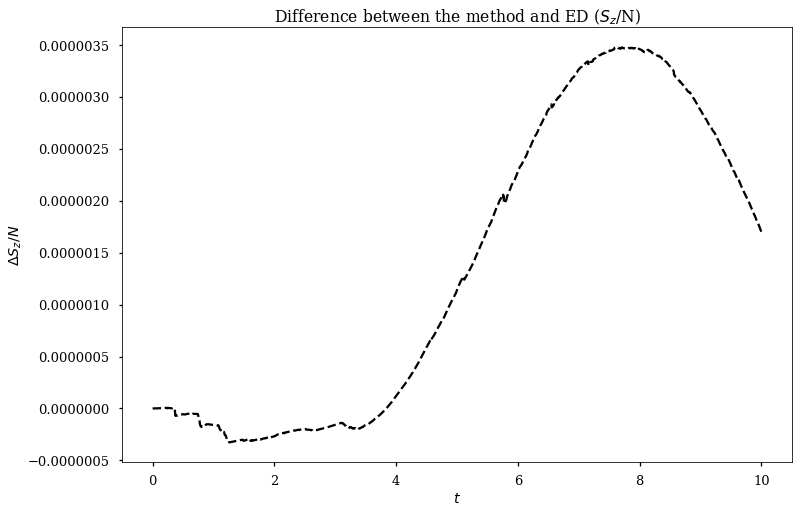

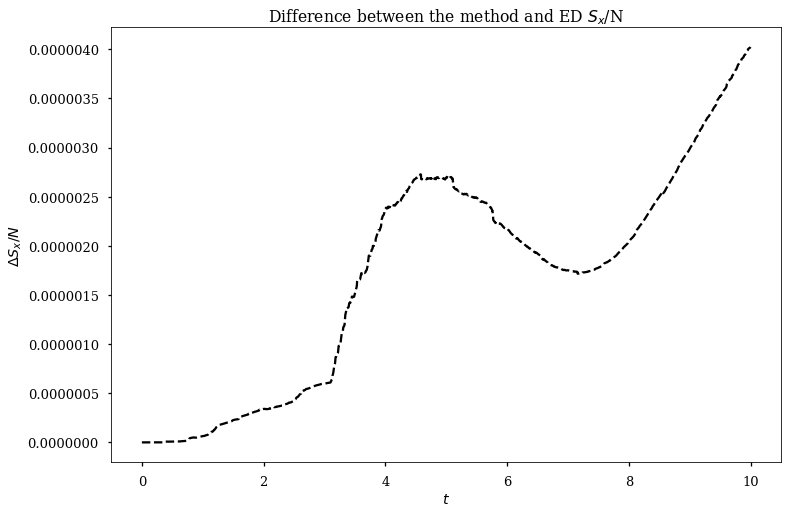

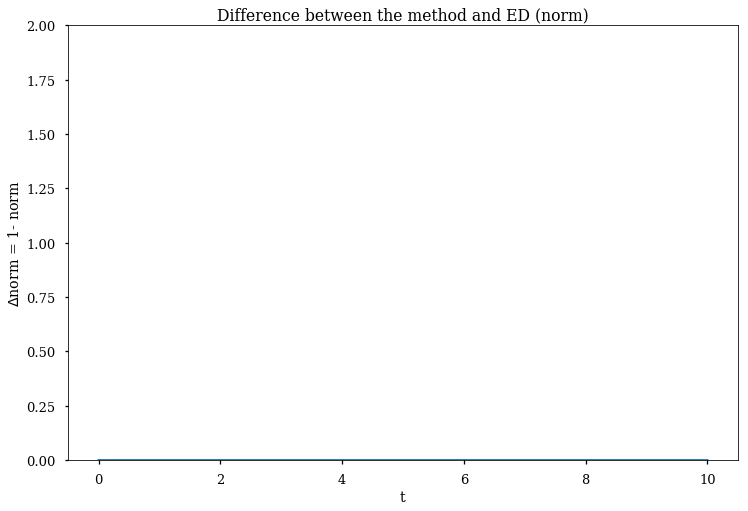

---------------------------------

time for ED was 2.580977201461792
time for dopri5 was 4.269151926040649


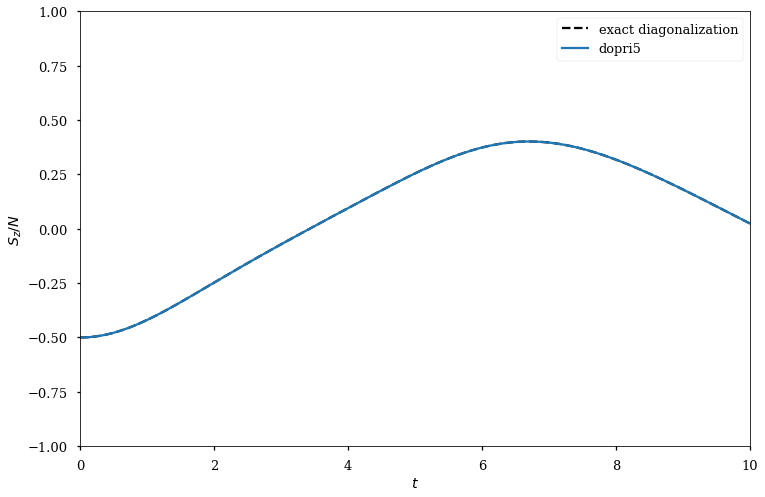

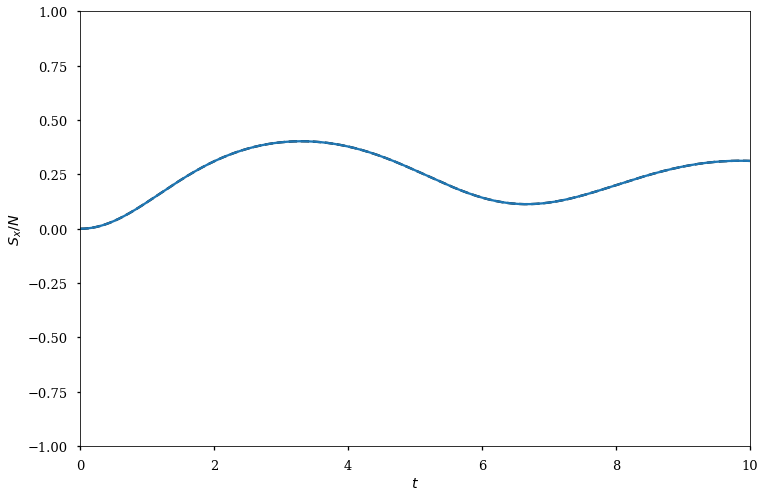

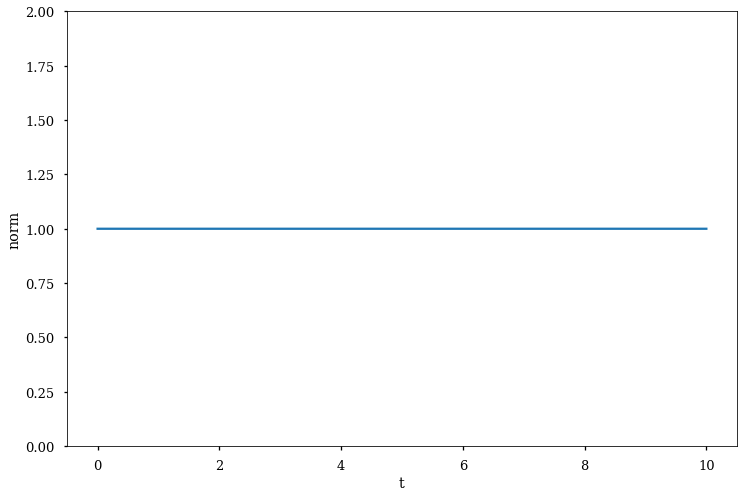

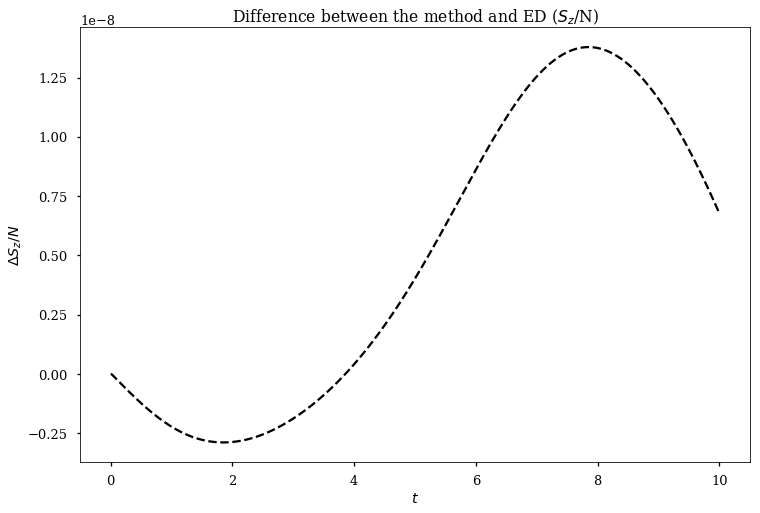

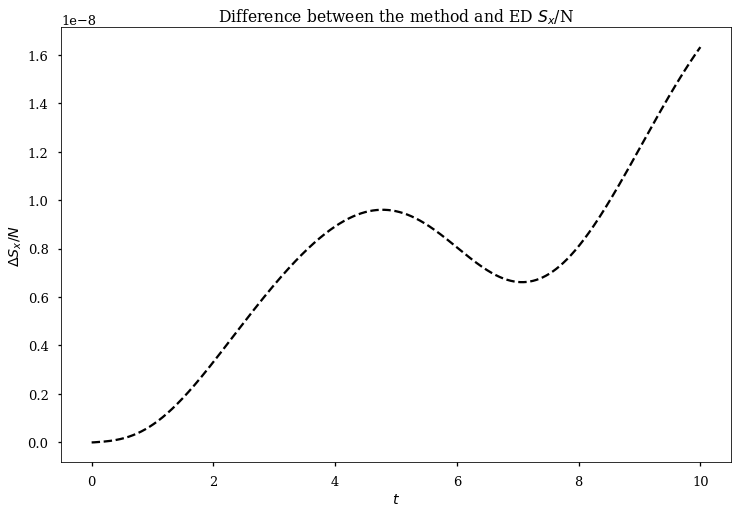

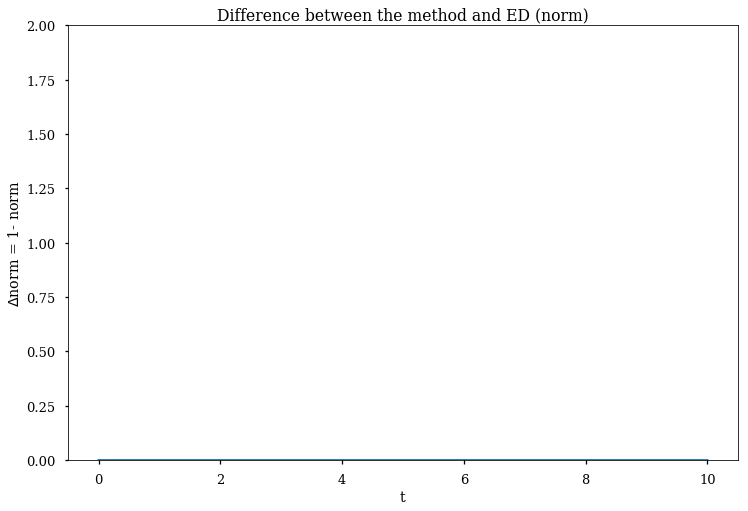

---------------------------------

time for ED was 1.0335619449615479
time for dop853 was 8.469713926315308


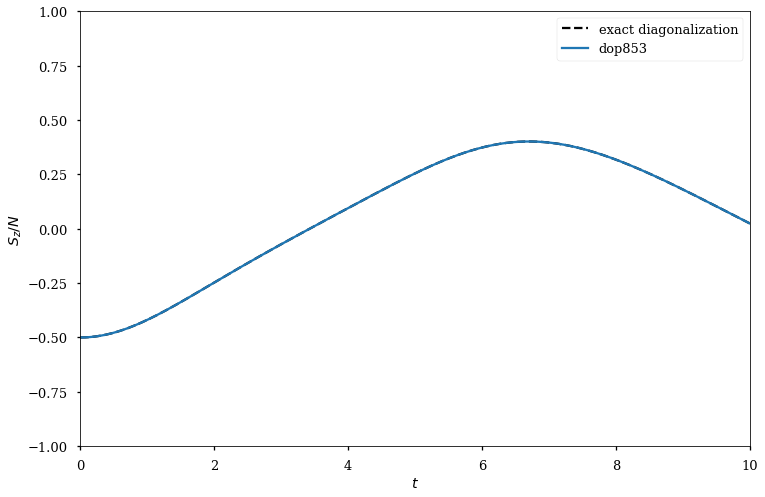

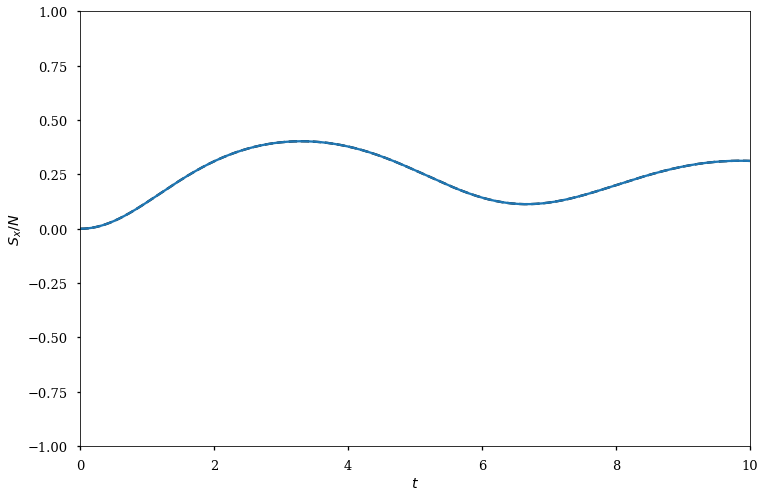

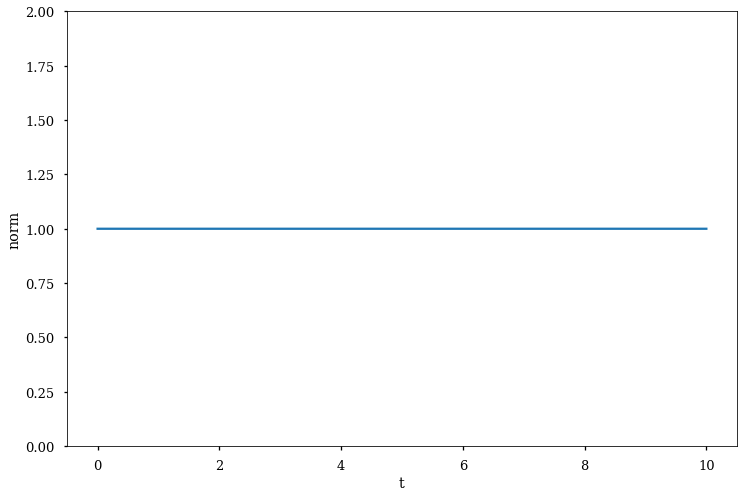

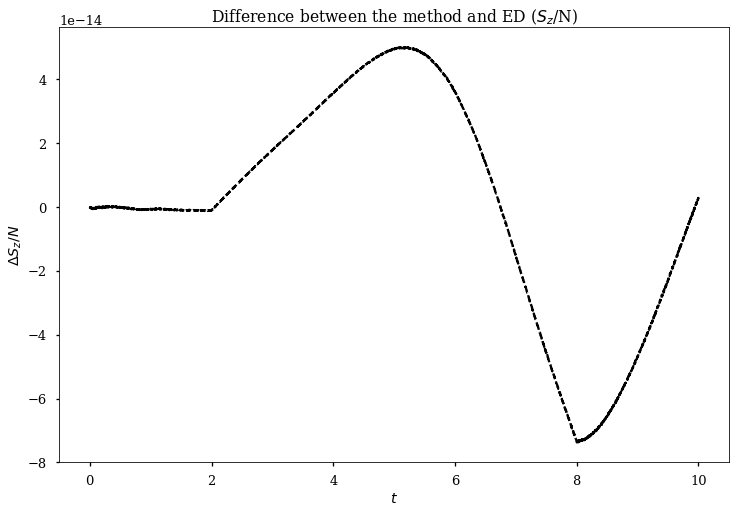

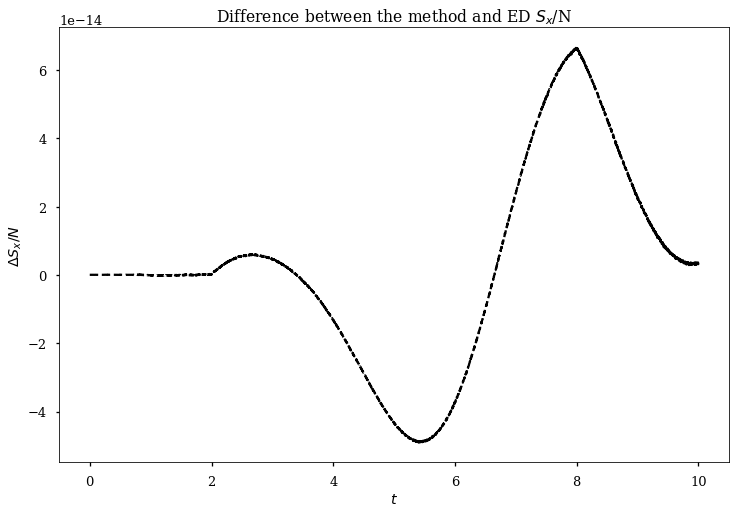

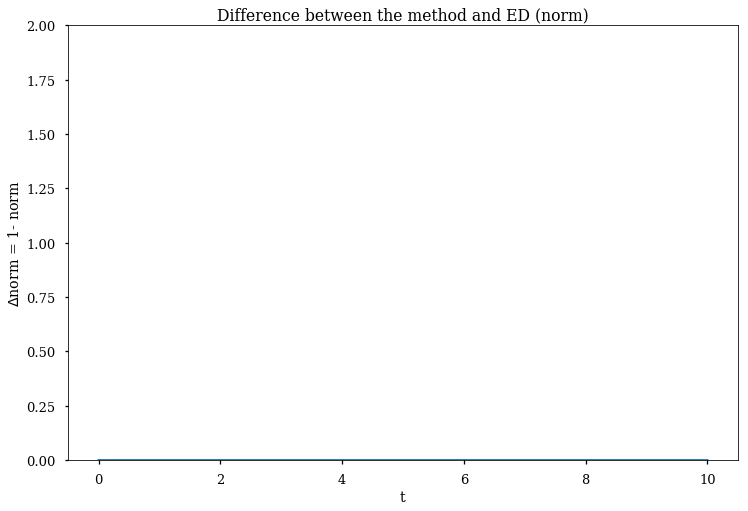

---------------------------------



In [39]:
#Trying out all the integrators
for integrator in scipy_integrators:
    analysis(integrator, dt, tend, N, analyze_step_size = False, difference_plots = True)
    print('---------------------------------')
    print( )

----- Jacobian False -----

time for ED was 1.7637479305267334
time for zvode was 1.367103099822998


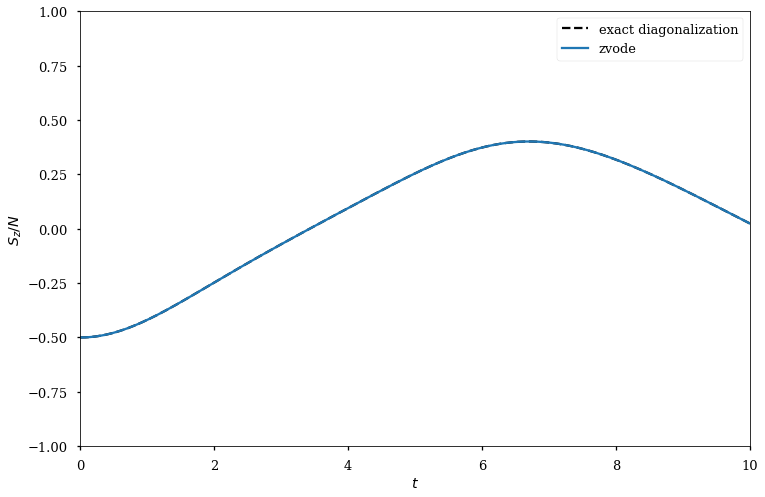

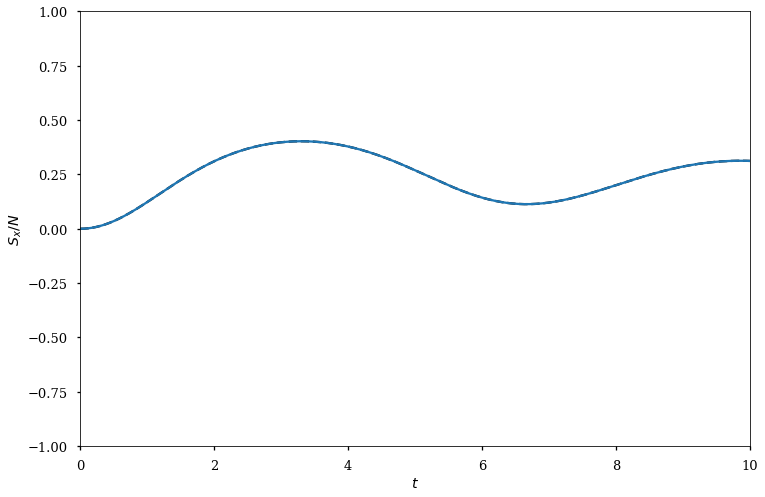

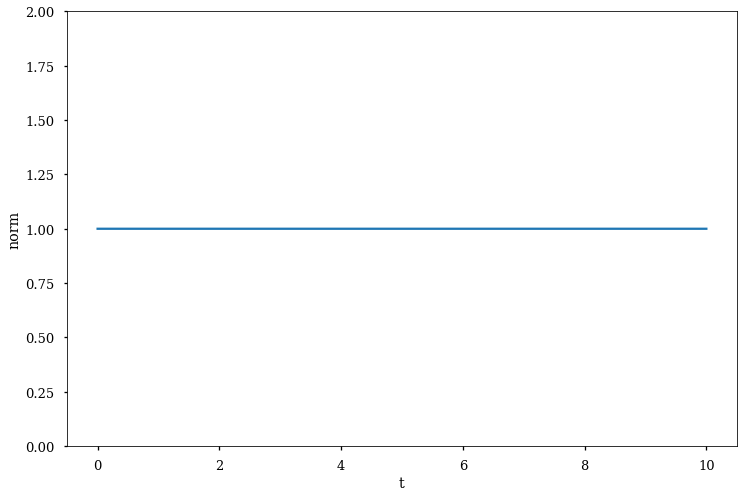

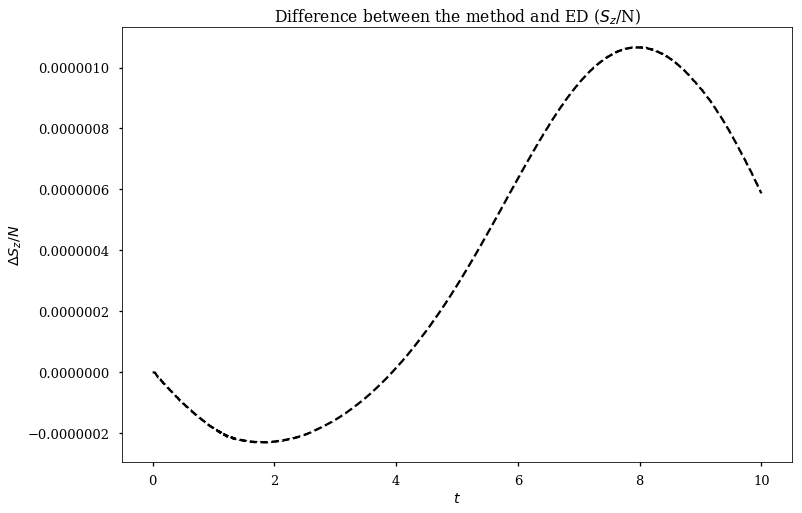

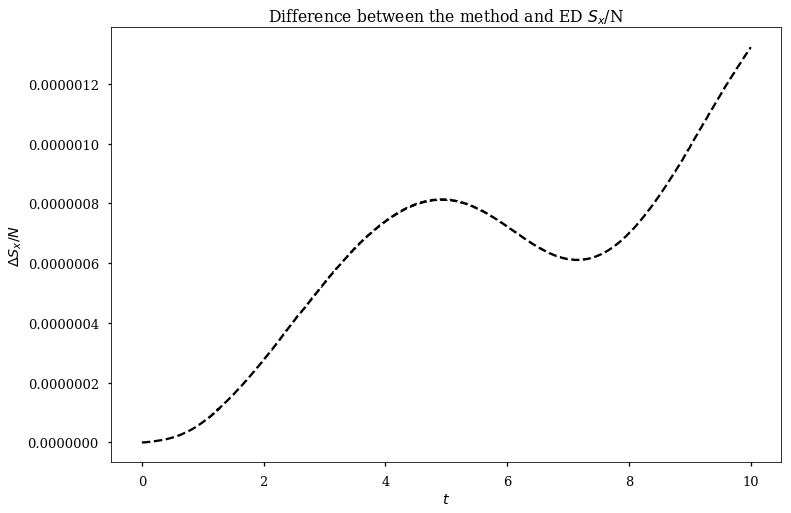

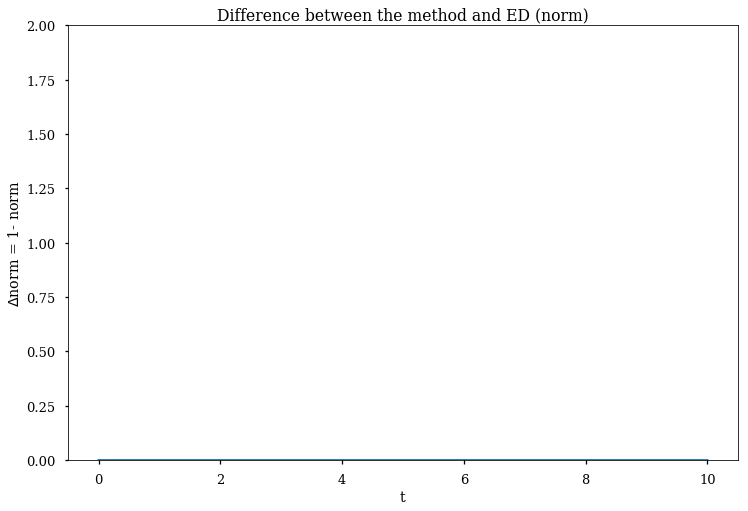

----- Jacobian True -----

time for ED was 3.5055387020111084
time for zvode was 1.8470189571380615


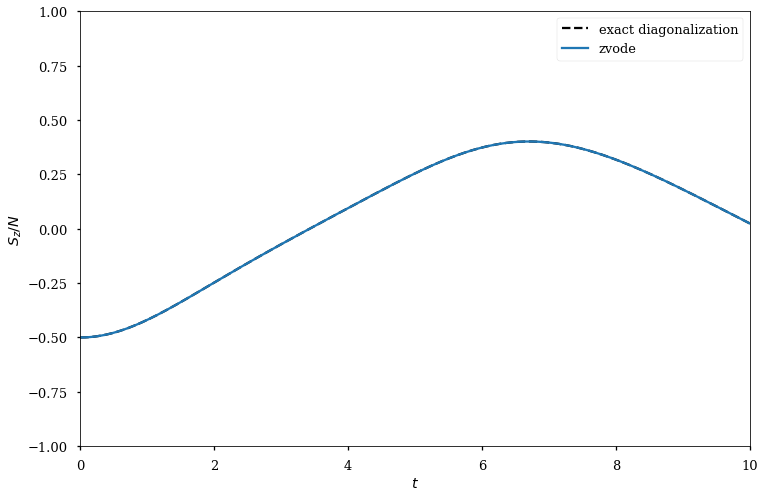

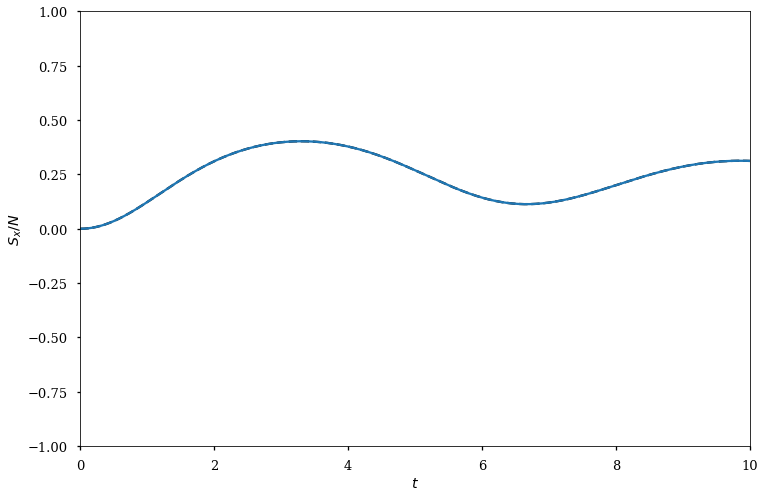

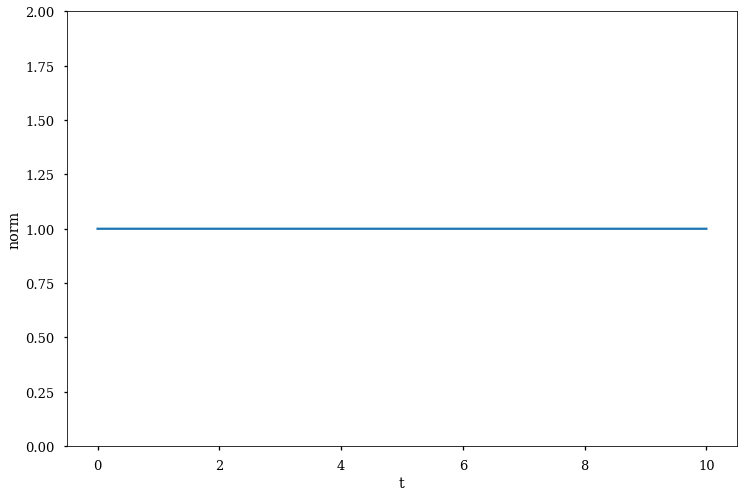

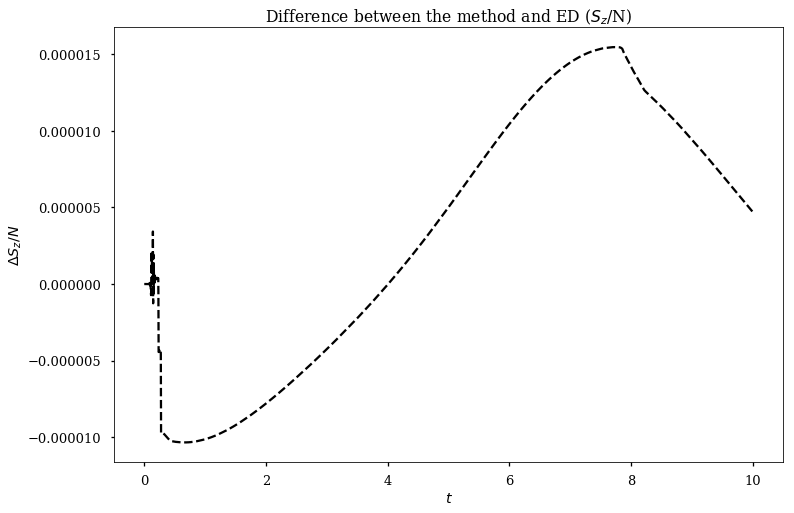

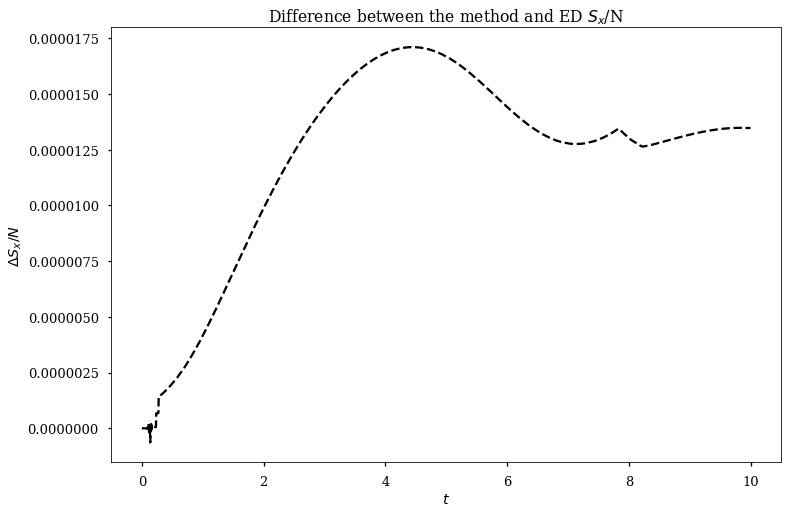

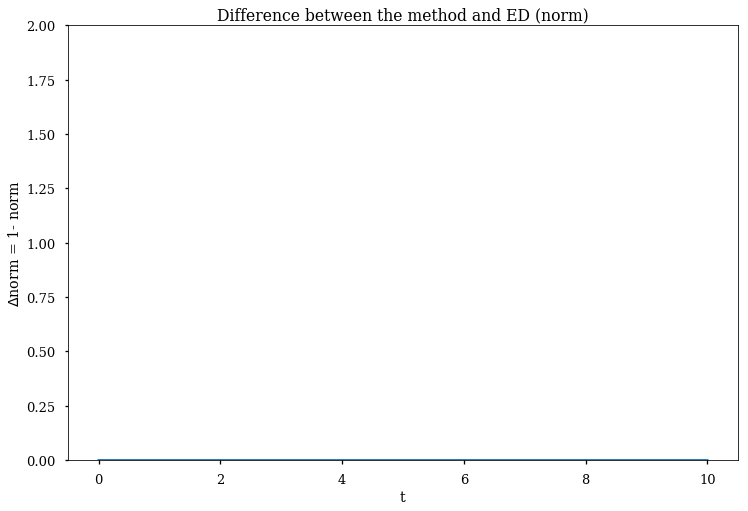

In [40]:
#Direct comparison of the best working method for True/False Jacobian
boolean = [False, True]

for jac_bool in boolean:
    print('----- Jacobian', str( jac_bool), '-----')
    print( )
    analysis(ode(f).set_integrator('zvode', method='adams', with_jacobian=jac_bool), dt, tend, N, analyze_step_size = False, difference_plots = True)

### Discussion of the results

In general, we found the same result as you. The zvode integrator works best, whereas some of the other constellations had some problems while deling with complex numbers that occur sometimes. Nevertheless we see, that there is a large amount of possible integrators to work with. A bit more precise discussion of the results is presented at the end of ecercise 4.

#### Is there a better method than using sparse matrices ?

We don't think that there is a more efficient than to work with sparse matrices. Only the necessaray information is stored and processed. This works pretty good for all the apllications we have already seen in this lecture.


#### Does using the Jacobian option improve the result?

In our case we didn't find a huge deviation between the case with or without the Jacobian as one can find in the difference plots we added in our method.

### Exercise 4 (20 points)

Next, we want to check how their runtime for integrating our ODE scales with the number of spins N (or equivalently the Hilbert space dimension) and compare this to ED. Below is a code where you have to insert only your numerical integrator initialization and stepping.

For me, ED was still faster for up to N=1000. Try to find an integrator that beats by ED implementation!

Describe and interpret your observations.

[Optional] You can also try odeint (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) and/or solve_ivp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). These modules are less object oriented and have a restricted choice of integrators but are somewhat easier to use. 

All the documentation pages have a lot of useful information about the integrators and even links to the original publications in which they were introduced.

[Optional] Implement a Krylov subpace method. A good refernce on the details of this is https://www.sciencedirect.com/science/article/pii/S0010465598000836
The wikipadia page on the Arnoldi iteration even has a python sourrce code for constructing the Krylov vectors.

This method should work much better than the scipy integrators...

---------------------------------
vode1

200
300
400
500
600
700
800
900
1000
1100
1200


/anaconda/lib/python3.6/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


1300
1400
1500
1600
1700
1800
1900
2000


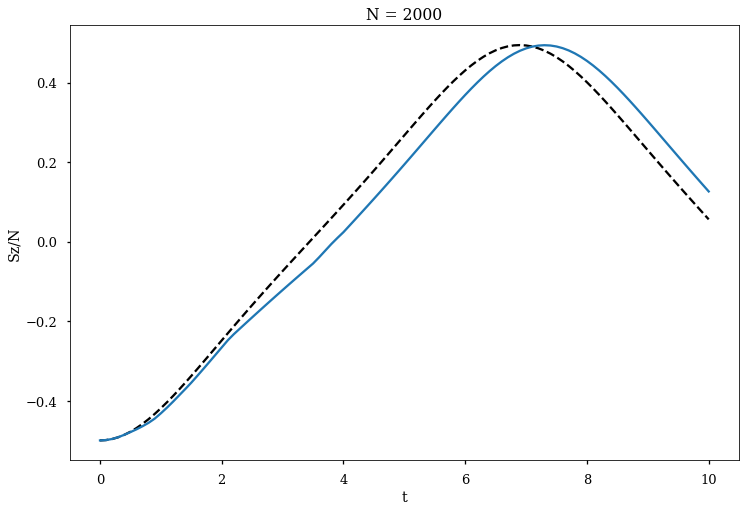

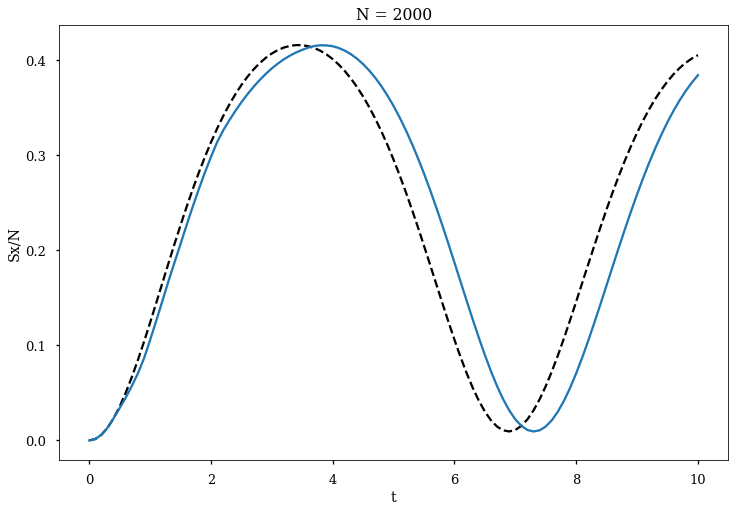

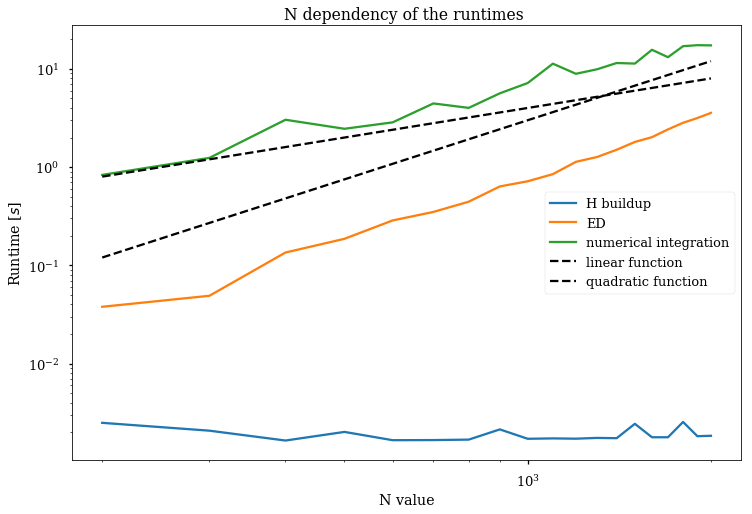

---------------------------------
vode2

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


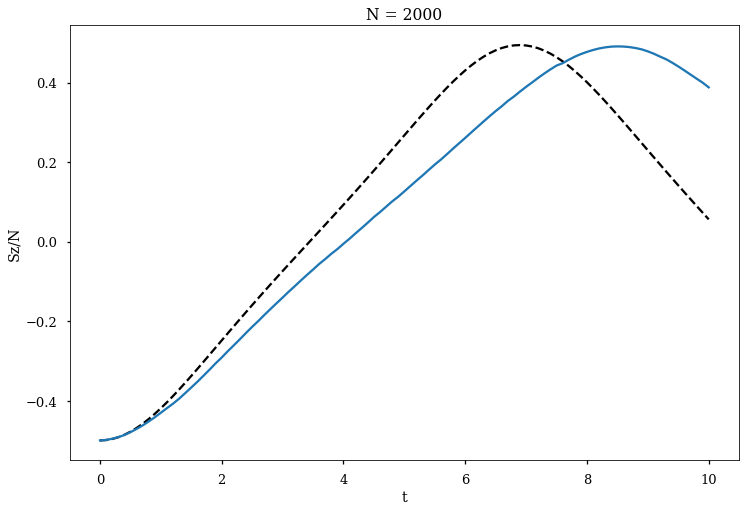

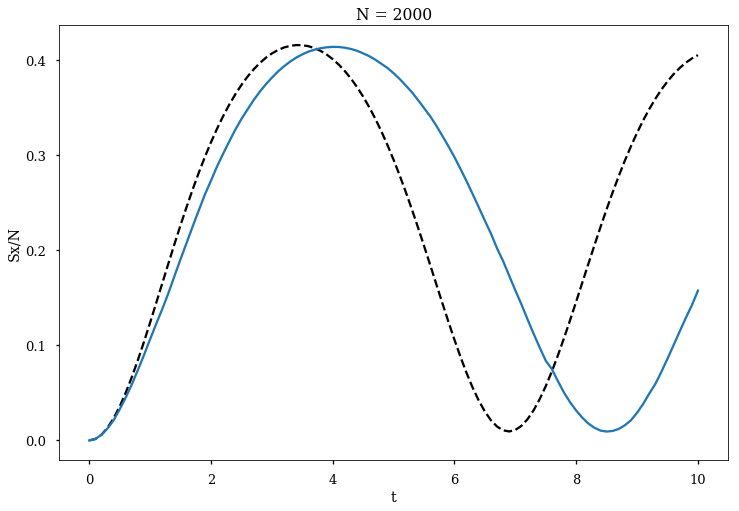

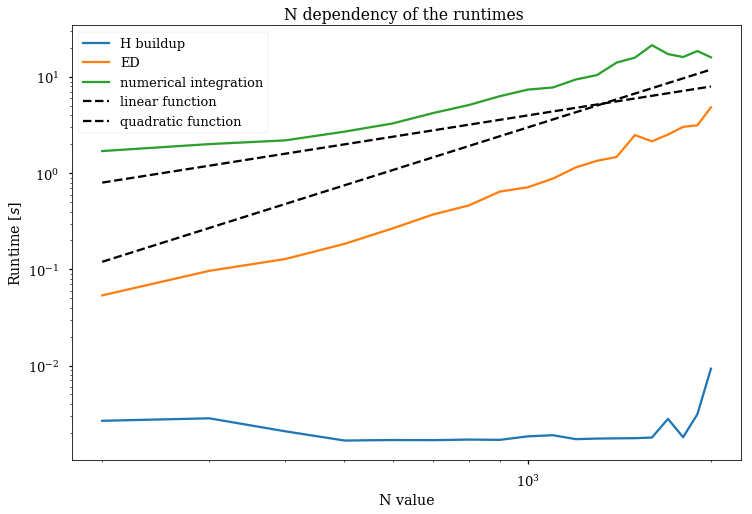

---------------------------------
zvode1

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


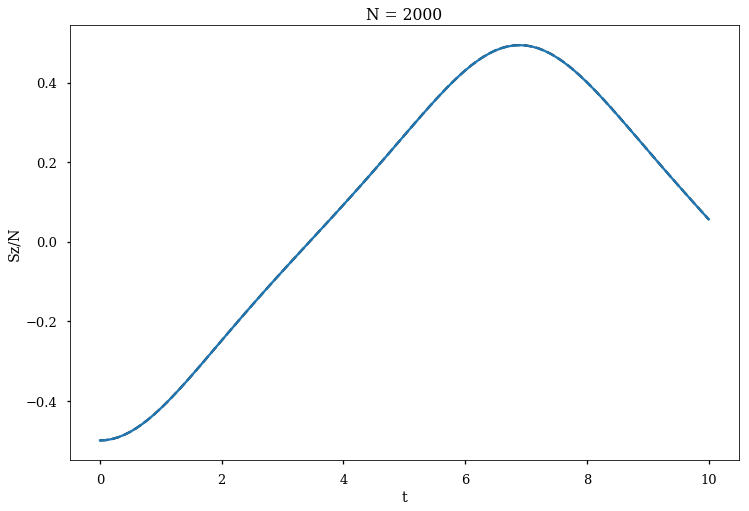

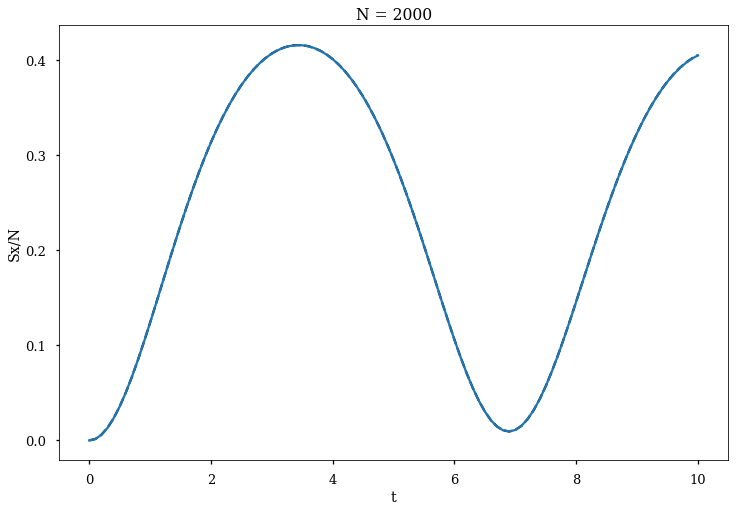

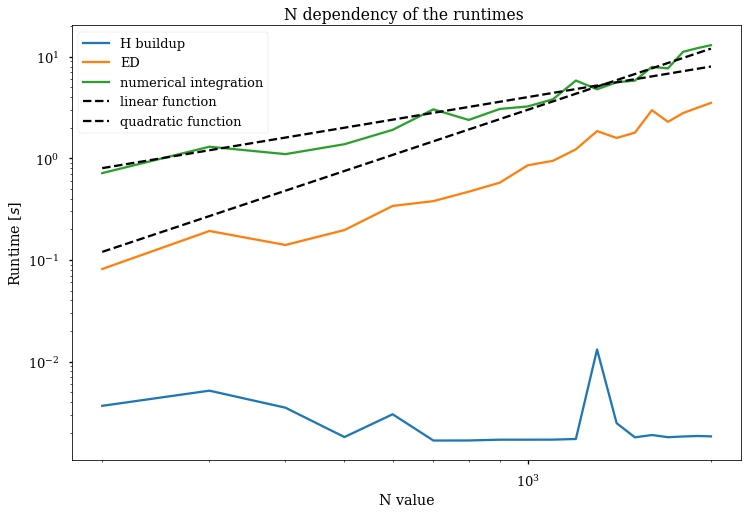

---------------------------------
zvode2

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


/anaconda/lib/python3.6/site-packages/scipy/integrate/_ode.py:869: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


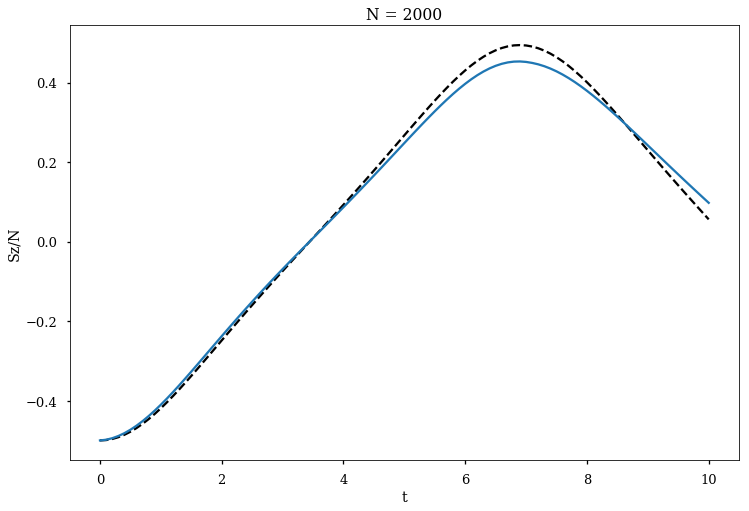

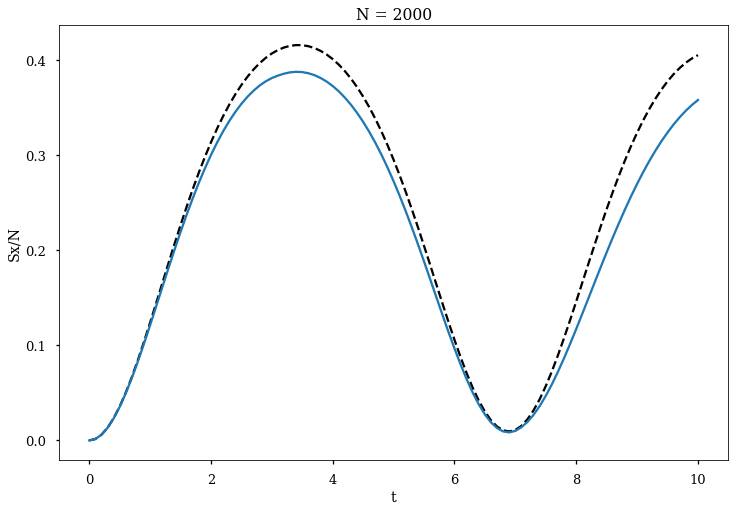

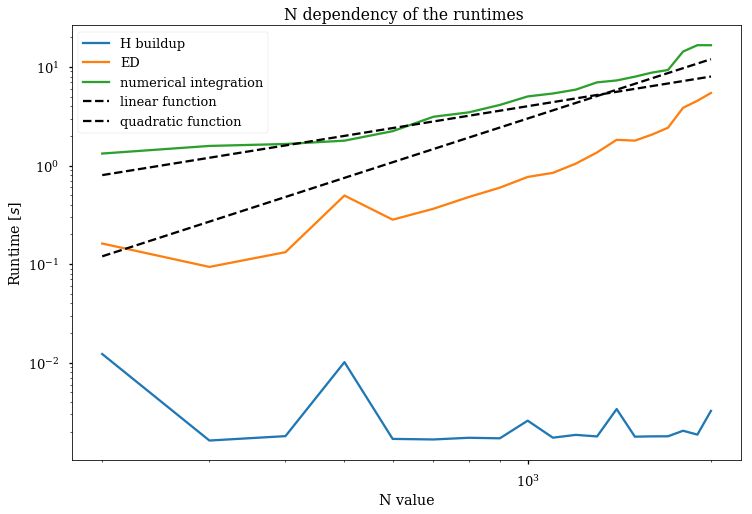

---------------------------------
lsoda

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


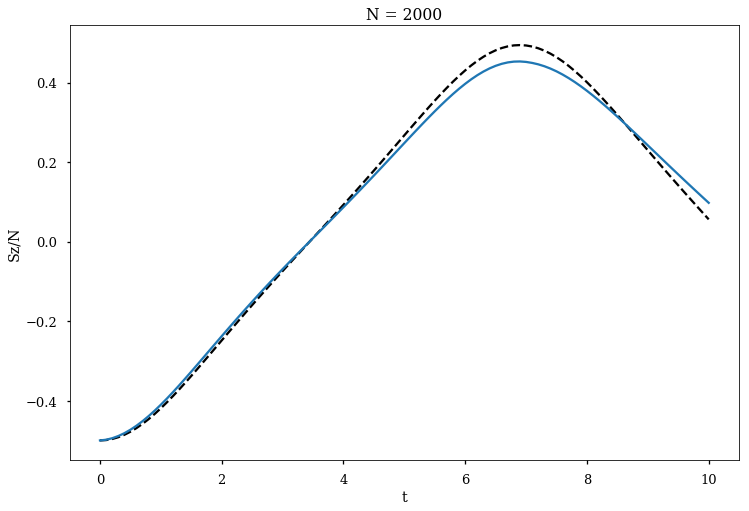

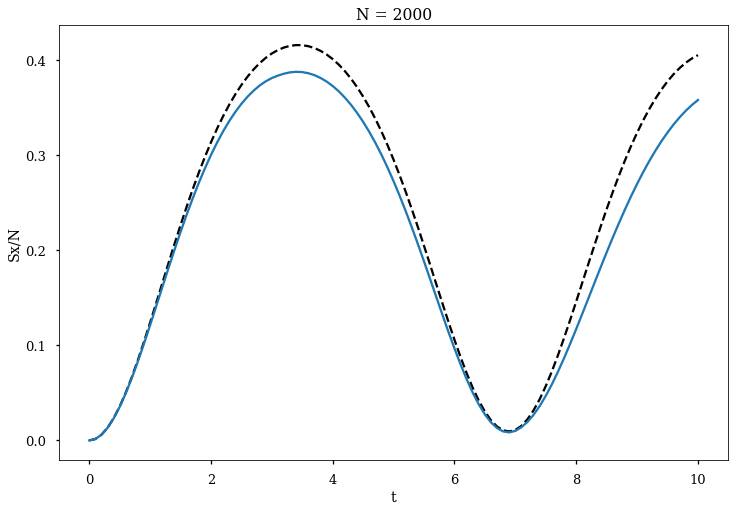

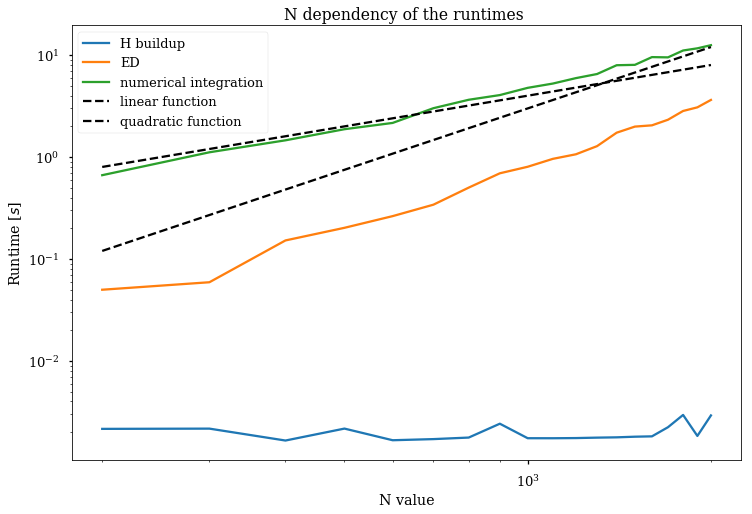

---------------------------------
dopri5

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


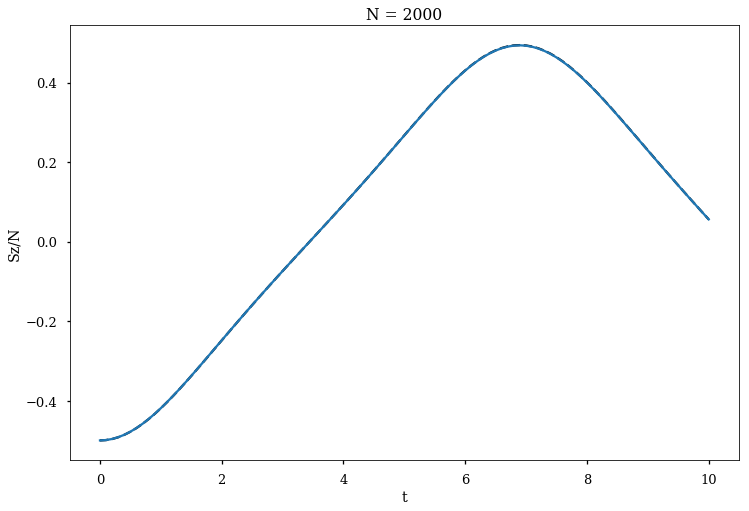

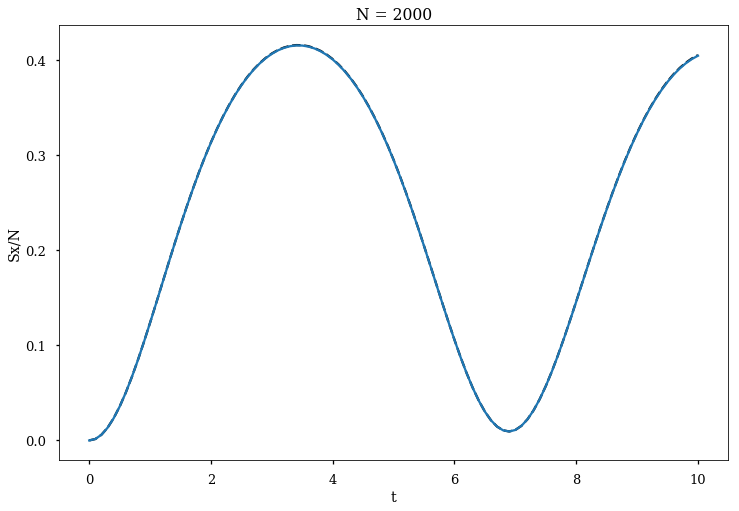

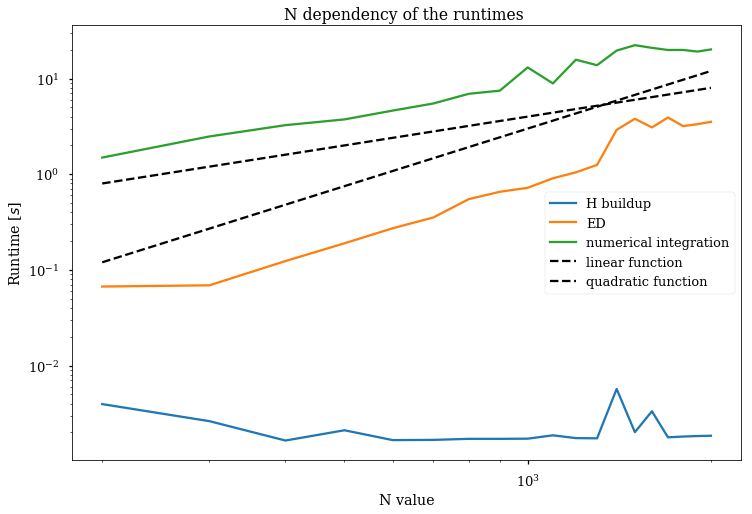

---------------------------------
dop853

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


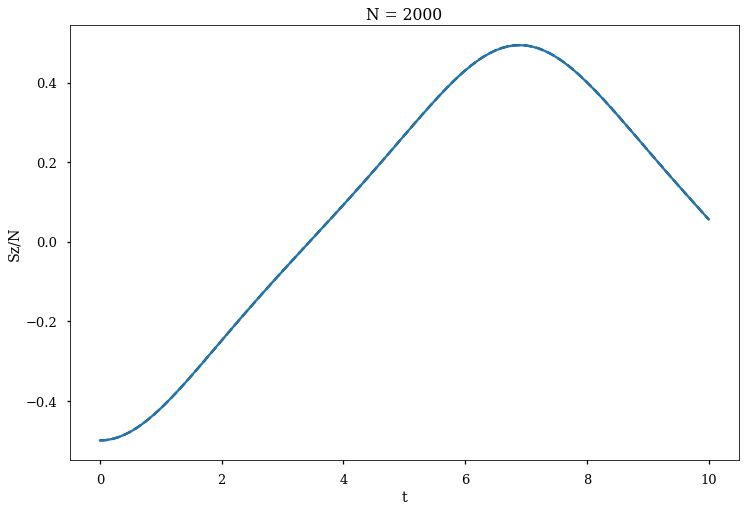

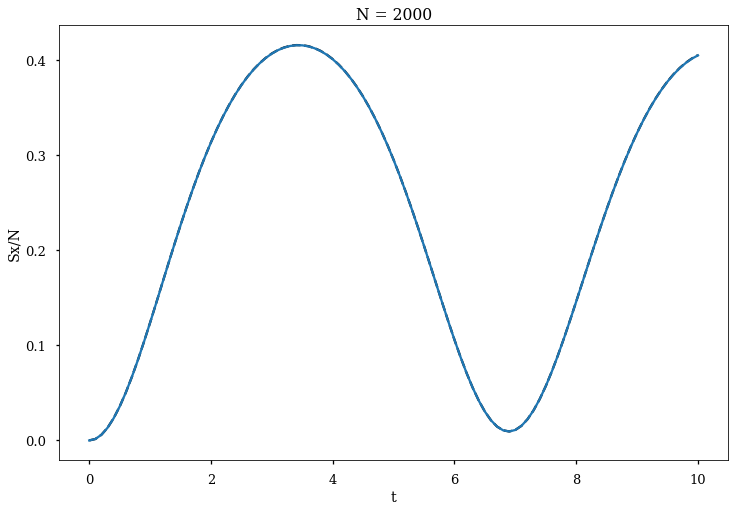

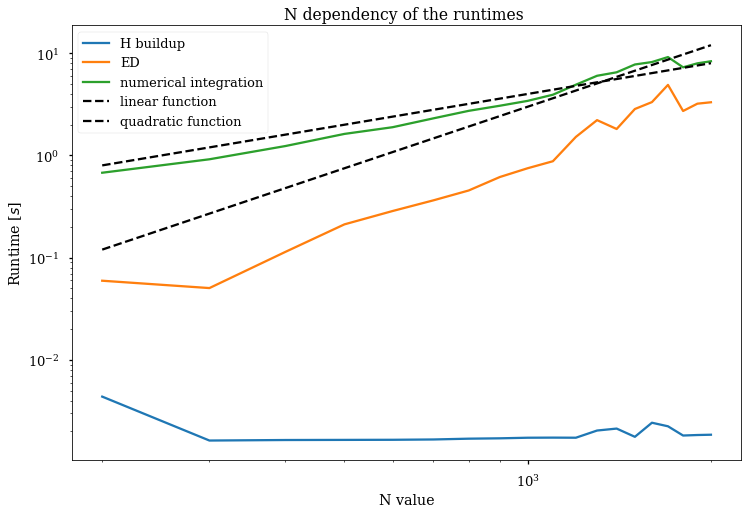

In [21]:
#this cell took 15 mins on my laptop to run
scipy_integrators = ["vode1", "vode2", "zvode1", "zvode2", "lsoda", "dopri5", "dop853"]

for name in scipy_integrators:
    print('---------------------------------')
    print(name)
    print()
    # Compare ED to scipy.integrate.ode
    dt = 0.1
    tend = 10
    tsteps = int(np.round(tend/dt))
    tvec = np.linspace(0,dt*tsteps,tsteps+1)

    omega = 0.6

    # running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
    Nvals = np.arange(200,2001,100, dtype = int) 

    observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
    runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

    for iN in range(len(Nvals)):

        N = Nvals[iN]
        print(N)
        dim = N+1
        ini = np.eye(1,dim,0)[0]

        Sz = buildSz(N)
        Sx = buildSx(N)

        t1=time.time()
        Hmat =buildH(N,omega)
        t2=time.time()
        runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

        # ED solution
        t1=time.time()
        evals, evecs = LA.eigh(Hmat.toarray())
        # calculate projections on eigenstates
        iniProj = evecs.conj().T @ ini
        # calculate time evolution
        for i in range(len(tvec)):
            Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
            Szval = Psit.conj().T @ Sz @ Psit
            Sxval = Psit.conj().T @ Sx @ Psit
            observables[0,i,iN] = Szval
            observables[1,i,iN] = Sxval
        t2=time.time()
        runtimes[1,iN] = t2-t1 # time for ED

        # integrator solution
        t1=time.time()
        t0 = 0

        if(name == "vode1"): integrator = complex_ode(f).set_integrator('vode', method='adams')
        elif(name == "vode2"): integrator = complex_ode(f).set_integrator('vode', method='bdf')
        elif(name == "zvode1"): integrator = ode(f).set_integrator('zvode', method='adams')
        elif(name == "zvode2"): integrator = ode(f).set_integrator('zvode', method='bdf')
        #lsoda = complex_ode(f).set_integrator('lsoda')
        elif(name == "dopri5"): integrator = complex_ode(f).set_integrator('dopri5')
        elif(name == "dop853"): integrator = complex_ode(f).set_integrator('dop853')
        
        #set up the integrator
        y0, t0 = ini, 0
        integrator.set_initial_value(y0, t0)
        
        i=0
        #initial values of observables
        Psit = ini
        i = 0
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        observables[2,i,iN] = Szval
        observables[3,i,iN] = Sxval

        i+=1
        #loop over integrator steps
        for i in range(1,len(tvec)):
            Psit = integrator.integrate(integrator.t+dt)
            Szval = Psit.conj().T @ Sz @ Psit
            Sxval = Psit.conj().T @ Sx @ Psit
            observables[2,i,iN] = Szval
            observables[3,i,iN] = Sxval

        t2=time.time()
        runtimes[2,iN] = t2-t1 # time for integration


    if np.max(observables.imag) > 0.001:
        print("Some observables have non-zero imaginary parts!!")

    observables = observables.real

    # plotting observables to check that integration was converged and accurate
    iN = -1
    plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--')
    plt.plot(tvec,observables[2,:,iN]/Nvals[iN])
    plt.title('N = '+ str(Nvals[iN]))
    plt.xlabel('t')
    plt.ylabel('Sz/N')
    plt.show()

    plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--')
    plt.plot(tvec,observables[3,:,iN]/Nvals[iN])
    plt.title('N = '+ str(Nvals[iN]))
    plt.xlabel('t')
    plt.ylabel('Sx/N')
    plt.show()

    # plotting N-dependence of runtimes
    plt.loglog(Nvals,runtimes[0], label = "H buildup")
    plt.loglog(Nvals,runtimes[1], label = "ED")
    plt.loglog(Nvals,runtimes[2], label = "numerical integration")
    plt.loglog(Nvals,0.004*Nvals,'k--', label = "linear function")
    plt.loglog(Nvals,3*10**-6*Nvals**2,'k--', label = "quadratic function")
    plt.title('N dependency of the runtimes ')
    plt.xlabel('N value')
    plt.ylabel('Runtime [$s$]')
    plt.legend()
    plt.show()

### Discussion of the results:

We tried out every possible configuration presented in the documentation of the class we used. Unfortunately we were note able to find an algorithm which was faster than exact diagonalization for all the N values up to 2000. <br>
Nevertheless we found some interesting properties:
- the time to build up the Hamiltonian was always negligible.
- the exact diagonalization was always faster. The reason for this behaviour could be that maybe we did not find the perfect setup for our explicit problem.
- the integrators work not perfectly good for high $N$, but are nevetheless a lot better and more stable compared to the two methods we implemented in exercise 2, as one would expect.
- there is a large amount of integrators to choose from. This means Python (with additional packages) provides a good resource for solving ODE's